In [2]:
import os
os.chdir("/mnt/c/Users/trang.le/Desktop/2D_shape_space")
import numpy as np
from PIL import Image, ImageSequence
from matplotlib import pyplot as plt
from utils import parameterize, plotting, helpers, dimreduction, coefs, alignment
from skimage.morphology import dilation, square, erosion
from imageio import imsave, imread
import pandas as pd
import scipy.cluster.hierarchy as spc
import seaborn as sns

In [3]:
LABEL_TO_ALIAS = {
  0: 'Nucleoplasm',
  1: 'NuclearM',
  2: 'Nucleoli',
  3: 'NucleoliFC',
  4: 'NuclearS',
  5: 'NuclearB',
  6: 'EndoplasmicR',
  7: 'GolgiA',
  8: 'IntermediateF',
  9: 'ActinF',
  10: 'Microtubules',
  11: 'MitoticS',
  12: 'Centrosome',
  13: 'PlasmaM',
  14: 'Mitochondria',
  15: 'Aggresome',
  16: 'Cytosol',
  17: 'VesiclesPCP',
  #18: 'Negative',
  #19:'Multi-Location',
}

all_locations = dict((v, k) for k,v in LABEL_TO_ALIAS.items())

COLORS = [
    '#f44336', '#e91e63', '#9c27b0', '#673ab7', '#3f51b5',
    '#2196f3', '#03a9f4', '#00bcd4', '#009688', '#4caf50',
    '#8bc34a', '#cddc39', '#ffeb3b', '#ffc107', '#ff9800',
    '#ff5722', '#795548', '#9e9e9e', '#607d8b', '#dddddd',
    '#212121', '#ff9e80', '#ff6d00', '#ffff00', '#76ff03',
    '#00e676', '#64ffda', '#18ffff',
]

COLORS_MAP = {
    "Nucleoplasm":"Blues",
    "GolgiA":"Greens",
    "IntermediateF":"Oranges",
    "Mitochondria":"Reds",
    "PlasmaM":"Purples",
    "Cytosol":"Greys"
    }

In [3]:
def coordinates_to_image(x, y, intensity, binarize=False, shift_x = None, shift_y = None):
    """

    Parameters
    ----------
    x : np.array shape (n_rings, n_positions)
        X coordiates of sampled points, each ring from nu_centroid-nu_membrane-cell_membrane has n_positions of x
    y : list of np.array shape (n_rings, n_positions)
        y coordiates of sampled points, each ring from nu_centroid-nu_membrane-cell_membrane has n_positions of y
    intensity : sampled intensity at (n_rings, n_positions) points
        DESCRIPTION.
    binarize : whether to binarize intensity or not
        binarize threshold = mean (TODO: udpate this to histogram normalization or other)
    shift_x : distance to add to all x coordinates
        If None, shift_y=min(x).
    shift_y : distance to add to all y coordinates
        If None, shift_y=min(y).

    Returns
    -------
    img : np.array
        output image.

    """
    assert x.shape == y.shape == intensity.shape
    
    x = np.array(np.round(x), dtype=int)
    y = np.array(np.round(y), dtype=int)
    
    if binarize:
        thres = intensity.mean()
        intensity = intensity > thres
    
    if shift_x == None:
        shift_x = x.min()
    if shift_y == None:
        shift_y = y.min()
    x = x - shift_x
    y = y - shift_y
    
    img = np.zeros((x.max()-x.min() + 1, y.max()-y.min() +1), dtype='float64')
    prev_x = []
    prev_y = []
    prev_int = []
    for i_, (ix, iy, intensity_ring) in enumerate(zip(x,y, intensity)):
        for ix_, iy_, intensity_ in zip(ix,iy, intensity_ring):
            img[ix_-5:ix_+5, iy_-5:iy_+5] = intensity_
        if i_ > 9:
            for ix_, iy_, intensity_ in zip((ix+prev_x)/2,(iy+prev_y)/2, (intensity_ring+prev_int)/2):
                img[int(ix_)-5:int(ix_)+5, int(iy_)-5:int(iy_)+5] = intensity_
        prev_x = ix
        prev_y = iy
        prev_int = intensity_ring
            
    return img

def investigate_organell_pc_var():
    """
    Sam

    Returns
    -------
    None.

    """
    shape_var_dir = "/mnt/c/Users/trang.le/Desktop/shapemode/U-2_OS/PCA_ratio8"
    organelle_dir = "/mnt/c/Users/trang.le/Desktop/shapemode/organelle"
    save_dir = "/mnt/c/Users/trang.le/Desktop/shapemode/avg_cell"
    
    # Plot all PCs for each organelle
    for org in all_locations.keys():
        fig,ax = plt.subplots(nrows=2, ncols=6)
        for i in range(1,13):
            intensities = np.load(f"{organelle_dir}/{org}_PC{i}_intensity.npy")  
            #coords = np.load(f"{organelle_dir}/{org}_PC{i}.npz")

            ax[(i-1) //6, (i-1) % 6].imshow(intensities.mean(axis=2).T)
            #plt.xticks(["nu_centroid","","","","","","","","","","nucleus","","","","","","","","","cell"])
            #X = np.zeros((21,10))
            ax[(i-1) //6, (i-1) % 6].set_title(f"PC{i}")
        fig.suptitle(org)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/allPC_{org}.png")
    
    # Plot all organelles for each PC
    for i in range(1,13):
        fig,ax = plt.subplots(nrows=3, ncols=6, figsize=(25,20))
        for org, k in all_locations.items():
            intensities = np.load(f"{organelle_dir}/{org}_PC{i}_intensity.npy")  
            #coords = np.load(f"{organelle_dir}/{org}_PC{i}.npz")

            ax[k //6, k % 6].imshow(intensities.mean(axis=2).T)
            #plt.xticks(["nu_centroid","","","","","","","","","","nucleus","","","","","","","","","cell"])
            #X = np.zeros((21,10))
            ax[k //6, k % 6].set_title(f"{org}", fontsize=30)
        fig.suptitle(f"PC{i}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"{save_dir}/allorg_PC{i}.png")

['ix_n', 'iy_n', 'ix_c', 'iy_c']


Lossy conversion from float64 to uint8. Range [0.0, 1.18368502486424]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1.0859311466522092]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1.0865188330795856]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this wa

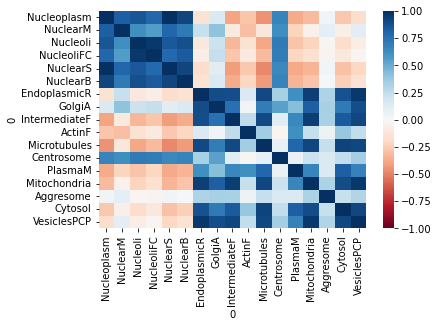

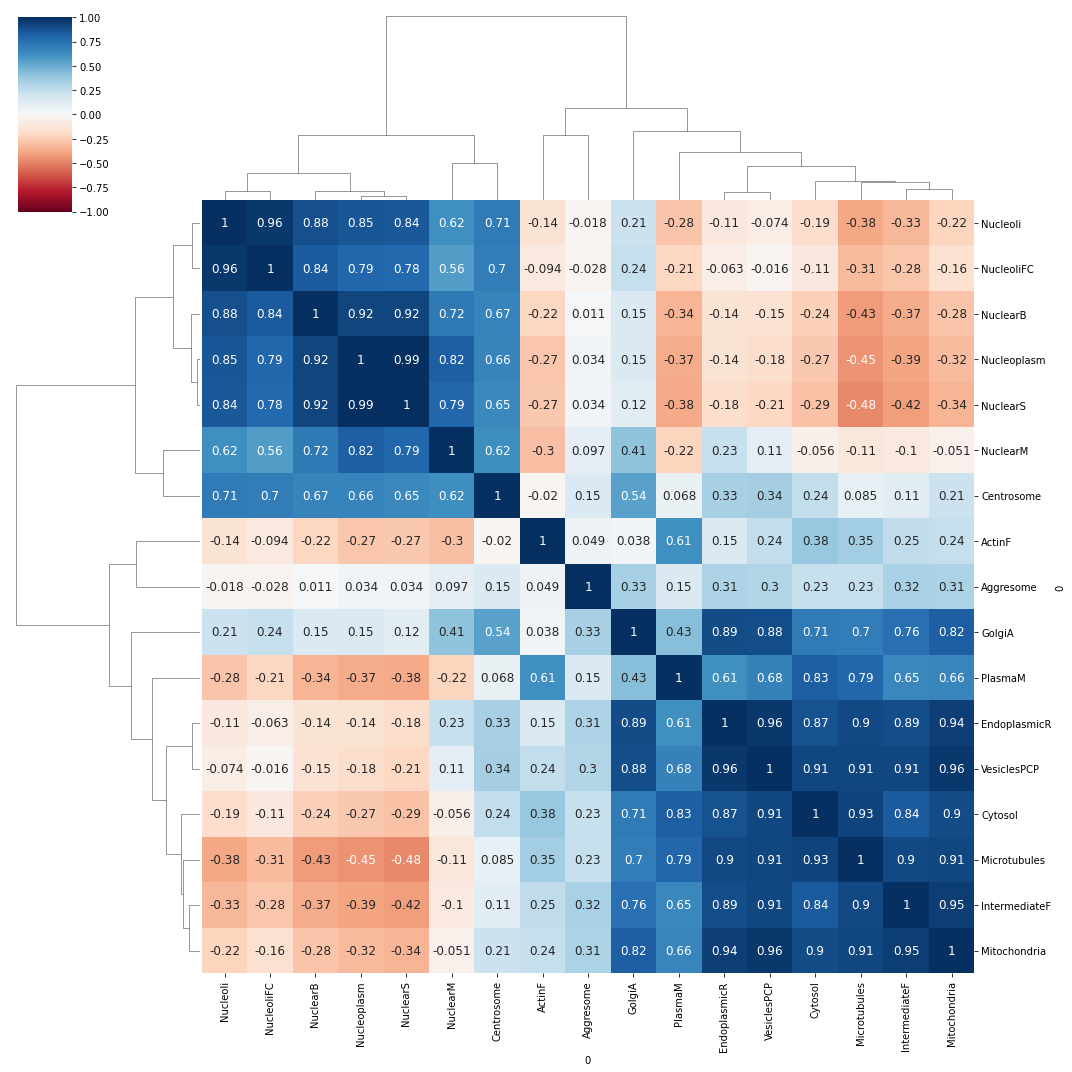

In [4]:
shape_var_dir = "/mnt/c/Users/trang.le/Desktop/shapemode/U-2_OS/PCA_ratio8"
organelle_dir = "/mnt/c/Users/trang.le/Desktop/shapemode/organelle"
save_dir = "/mnt/c/Users/trang.le/Desktop/shapemode/avg_cell"
avg_coords = np.load(f"{shape_var_dir}/Avg_cell.npz")
print(avg_coords.files)
ix_n = avg_coords["ix_n"] #[avg_coords["ix_n"][i] for i in range(0,1280,5)]
iy_n = avg_coords["iy_n"] #[avg_coords["iy_n"][i] for i in range(0,1280,5)]
ix_c = avg_coords["ix_c"] #[avg_coords["ix_c"][i] for i in range(0,1280,5)]
iy_c = avg_coords["iy_c"] #[avg_coords["iy_c"][i] for i in range(0,1280,5)]
x_,y_ = parameterize.get_coordinates(
            np.concatenate([ix_n, iy_n]), 
            np.concatenate([ix_c, iy_c]), 
            [0,0], 
            n_isos = [10,10], 
            plot=False)

avg_organelle_intensity = []
norm = plt.Normalize(vmin=0, vmax=1)
for org in all_locations.keys():
    intensities = np.load(f"{organelle_dir}/{org}_PC1_intensity.npy")       
    intensities = intensities[4:6].sum(axis=0) #avg 2 slice in the middle
    avg_organelle_intensity += [[org] + intensities.flatten().tolist()]
    img = coordinates_to_image(np.asarray(x_), np.asarray(y_), intensities)
    imsave(f"{save_dir}/{org}.png",img)
    #img = coordinates_to_image(np.asarray(x_), np.asarray(y_), intensities, binarize=True)
    plt.imshow(dilation(erosion(img), square(7)))
    plt.tight_layout()
    plt.axis("off")
    plt.savefig(f"{save_dir}/{org}.jpg", bbox_inches="tight")
    plt.close()
avg_organelle_intensity = pd.DataFrame(avg_organelle_intensity)
avg_organelle_intensity.index = avg_organelle_intensity.iloc[:,0]
avg_organelle_intensity.drop([0], axis=1, inplace=True)
# No mitotic spindle in the average cells (which makes sense!) so remove the org
covar_mat = avg_organelle_intensity.transpose().drop(["MitoticS"],axis=1).corr()
sns.heatmap(covar_mat, cmap="RdBu", vmin=-1, vmax=1)
sns.clustermap(covar_mat, method="complete", cmap='RdBu', annot=True, 
           annot_kws={"size": 12}, vmin=-1, vmax=1, figsize=(15,15))

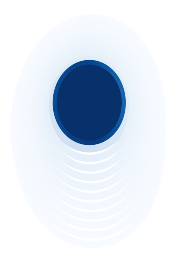

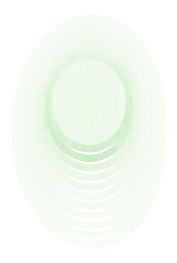

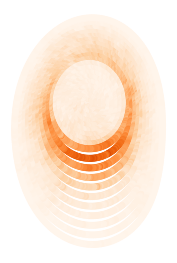

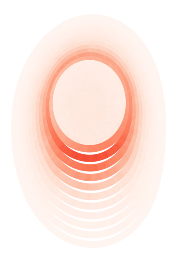

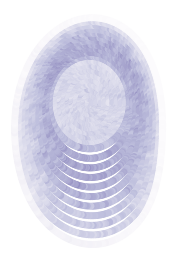

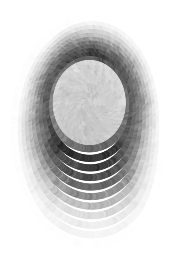

In [5]:
for org,org_color in COLORS_MAP.items():
    intensities = np.load(f"{organelle_dir}/{org}_PC1_intensity.npy")       
    intensities = intensities[4:6].sum(axis=0) #avg 2 slice in the middle
    fig, ax = plt.subplots()
    for i,(xi,yi,intensity) in enumerate(zip(x_,y_,intensities)):
        ax.scatter(xi, yi,c=intensity, norm=norm, cmap= org_color)
    ax.axis("scaled")
    fig.tight_layout()
    ax.axis("off")
    #ax.figure.savefig(f"{save_dir}/{org}.jpg", bbox_inches="tight")

/tmp/ipykernel_730/3513420477.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(nrows=3, ncols=6, figsize=(25,20))


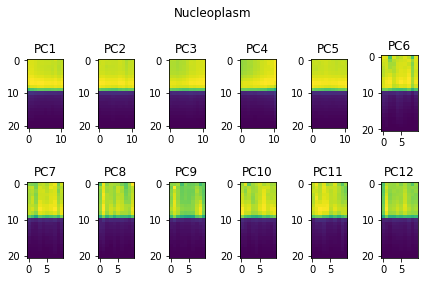

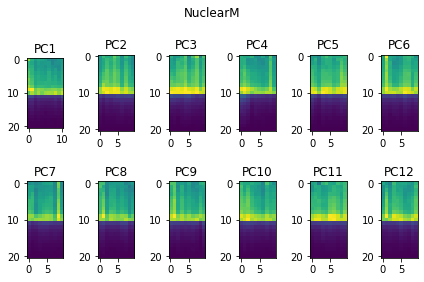

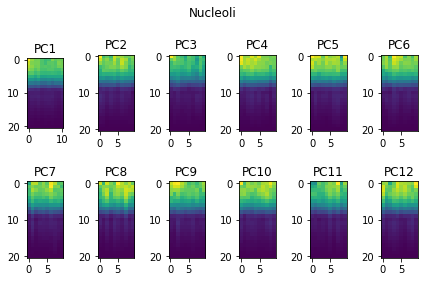

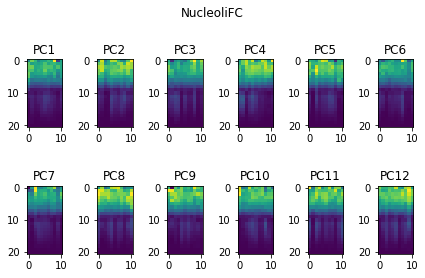

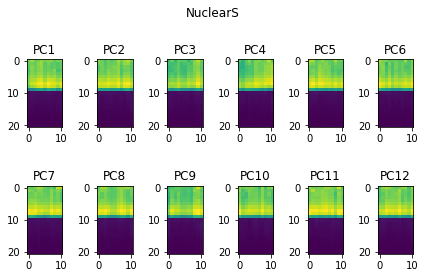

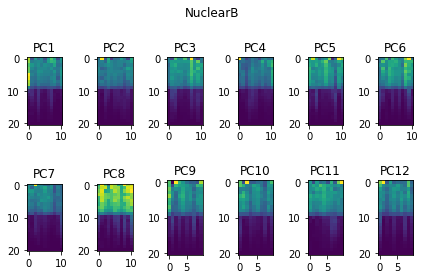

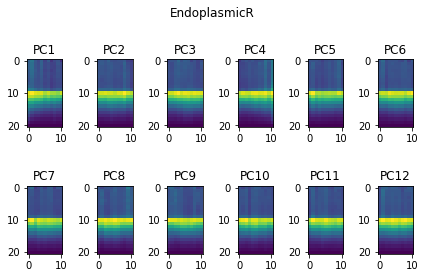

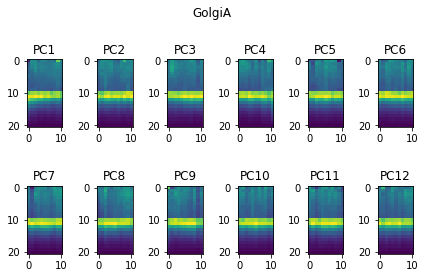

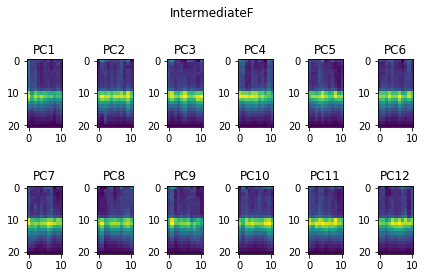

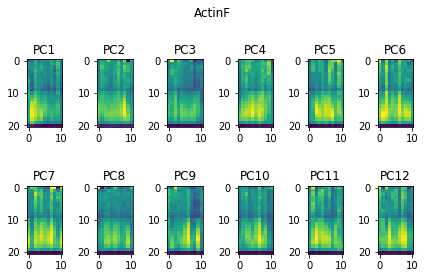

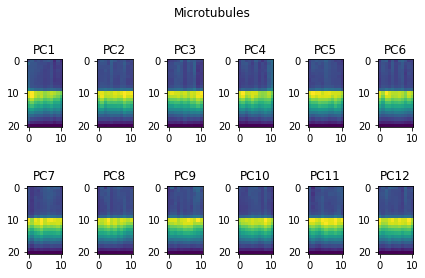

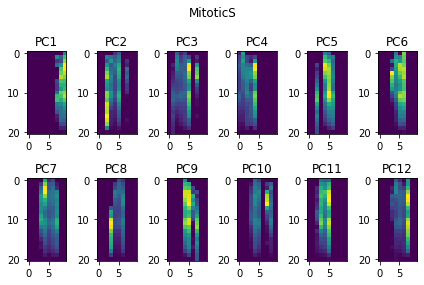

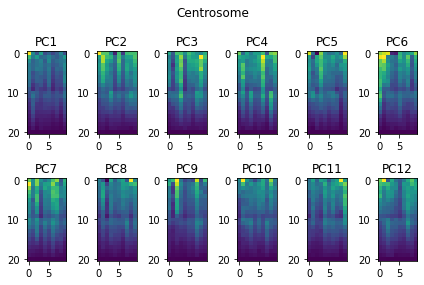

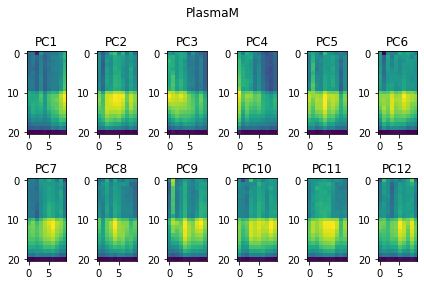

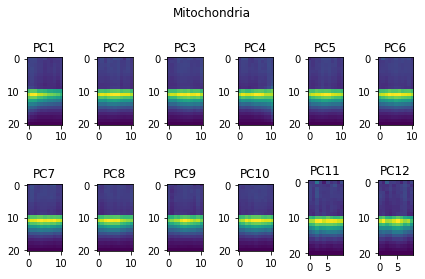

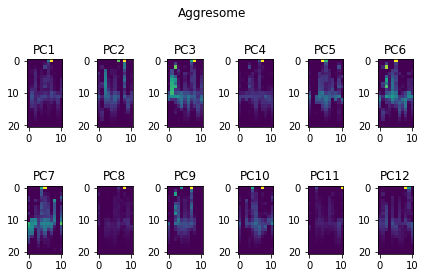

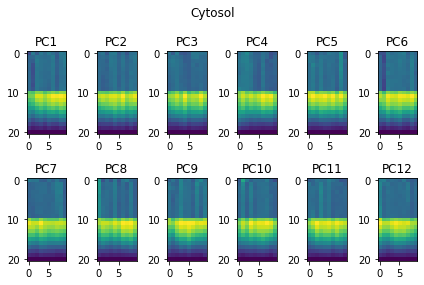

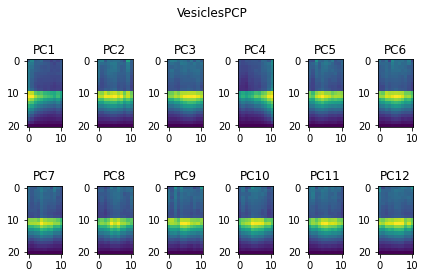

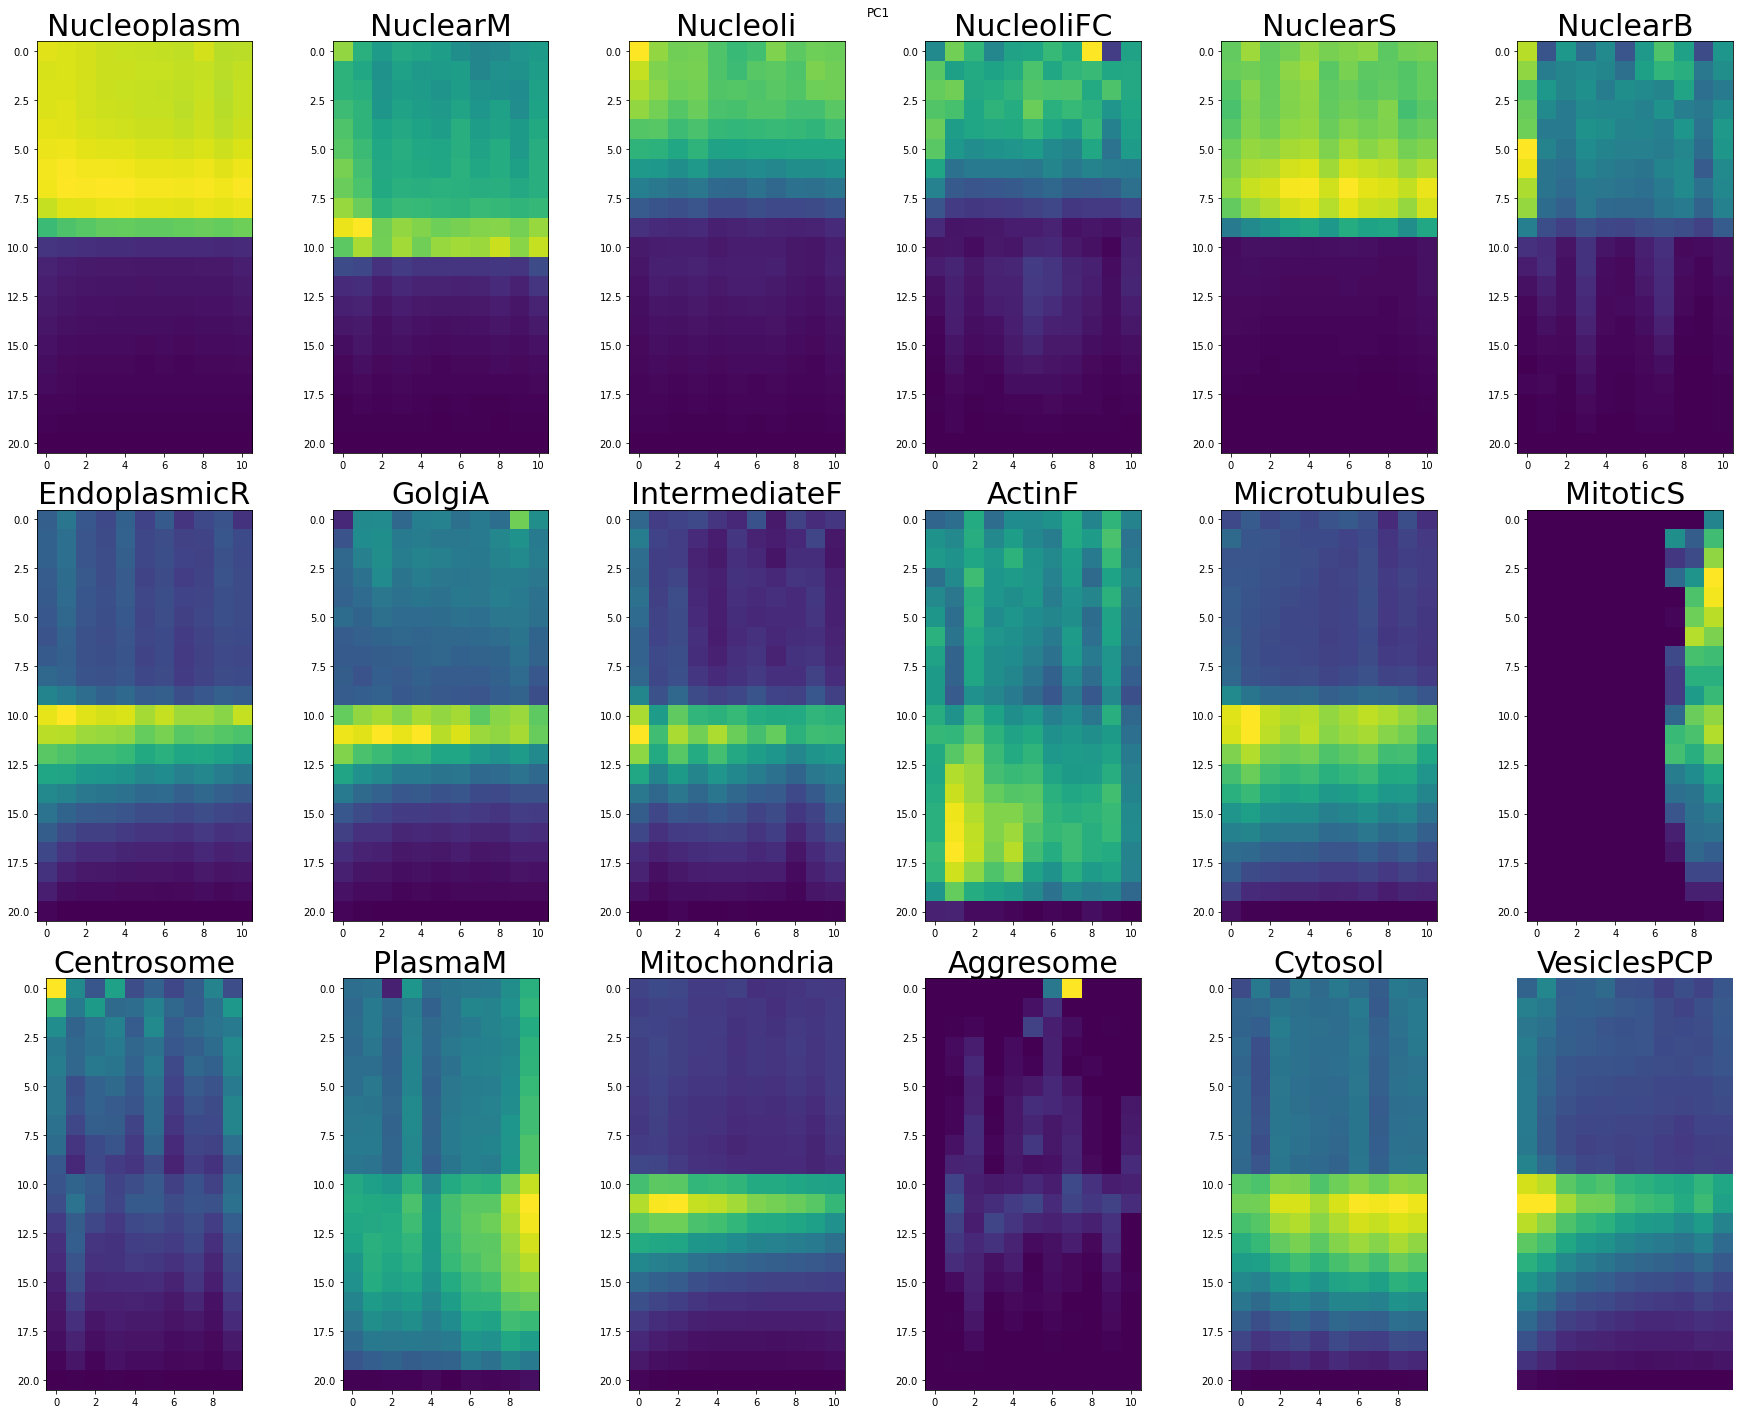

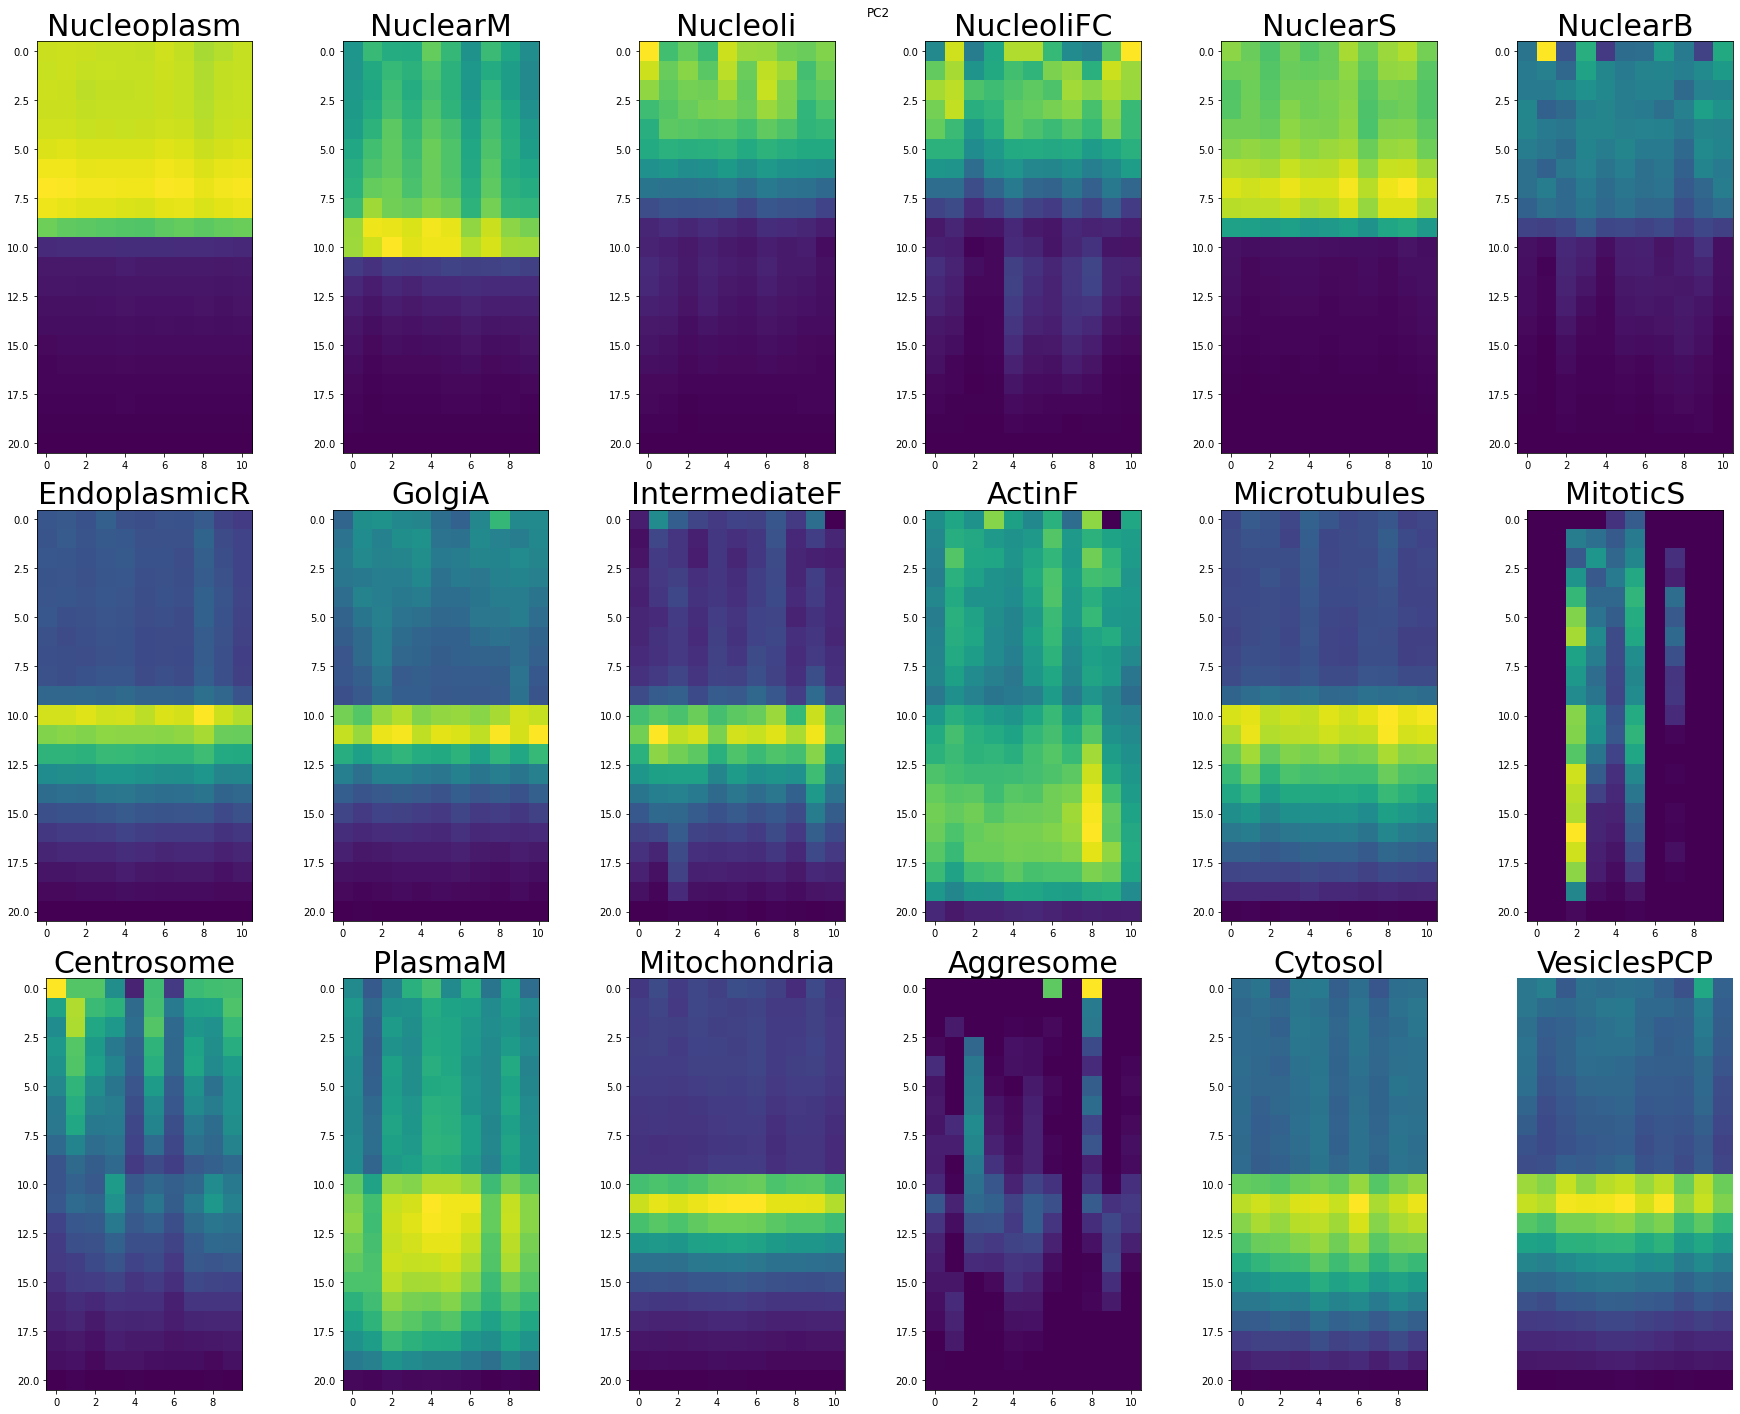

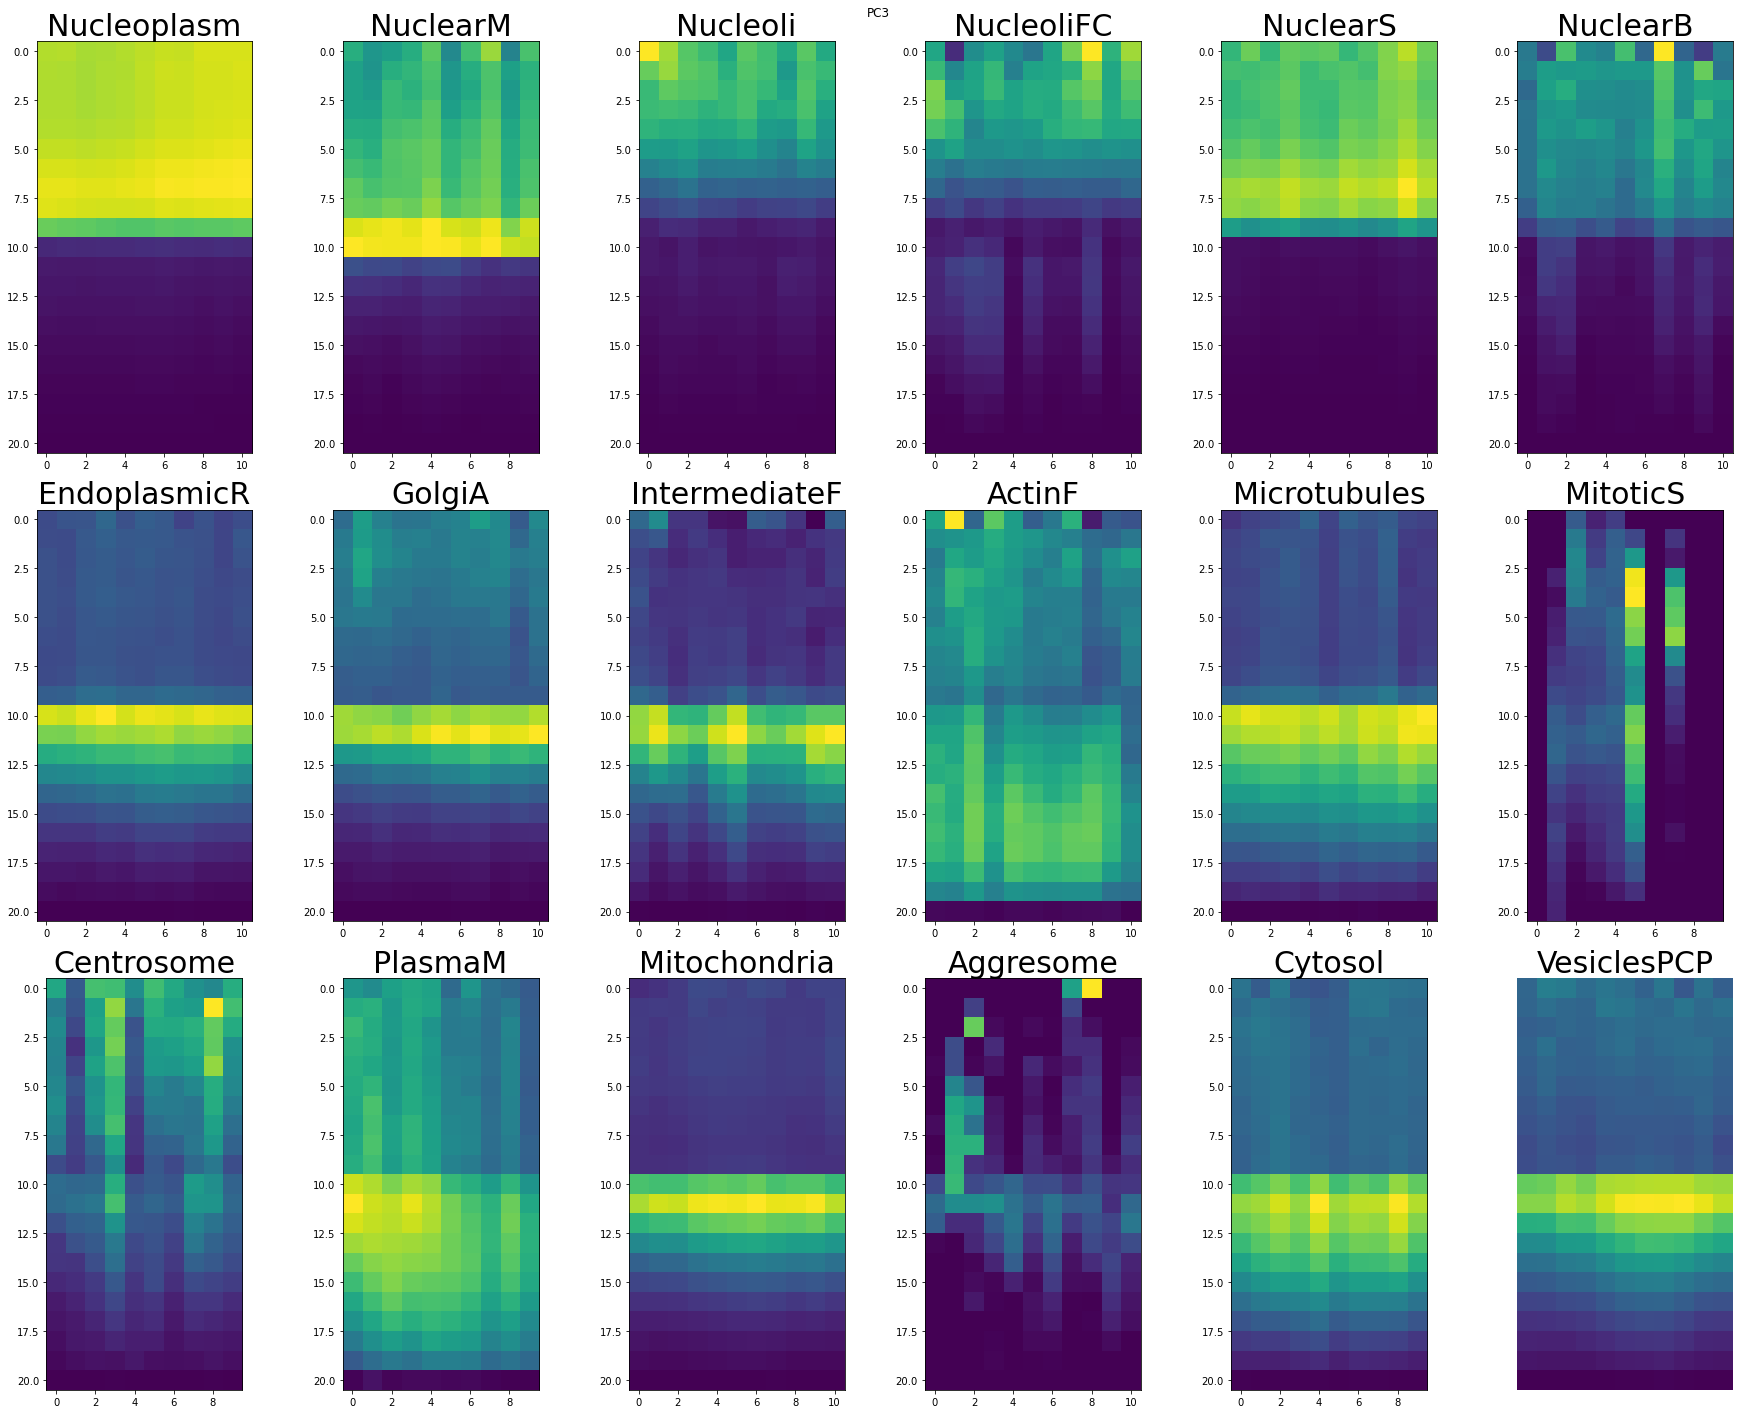

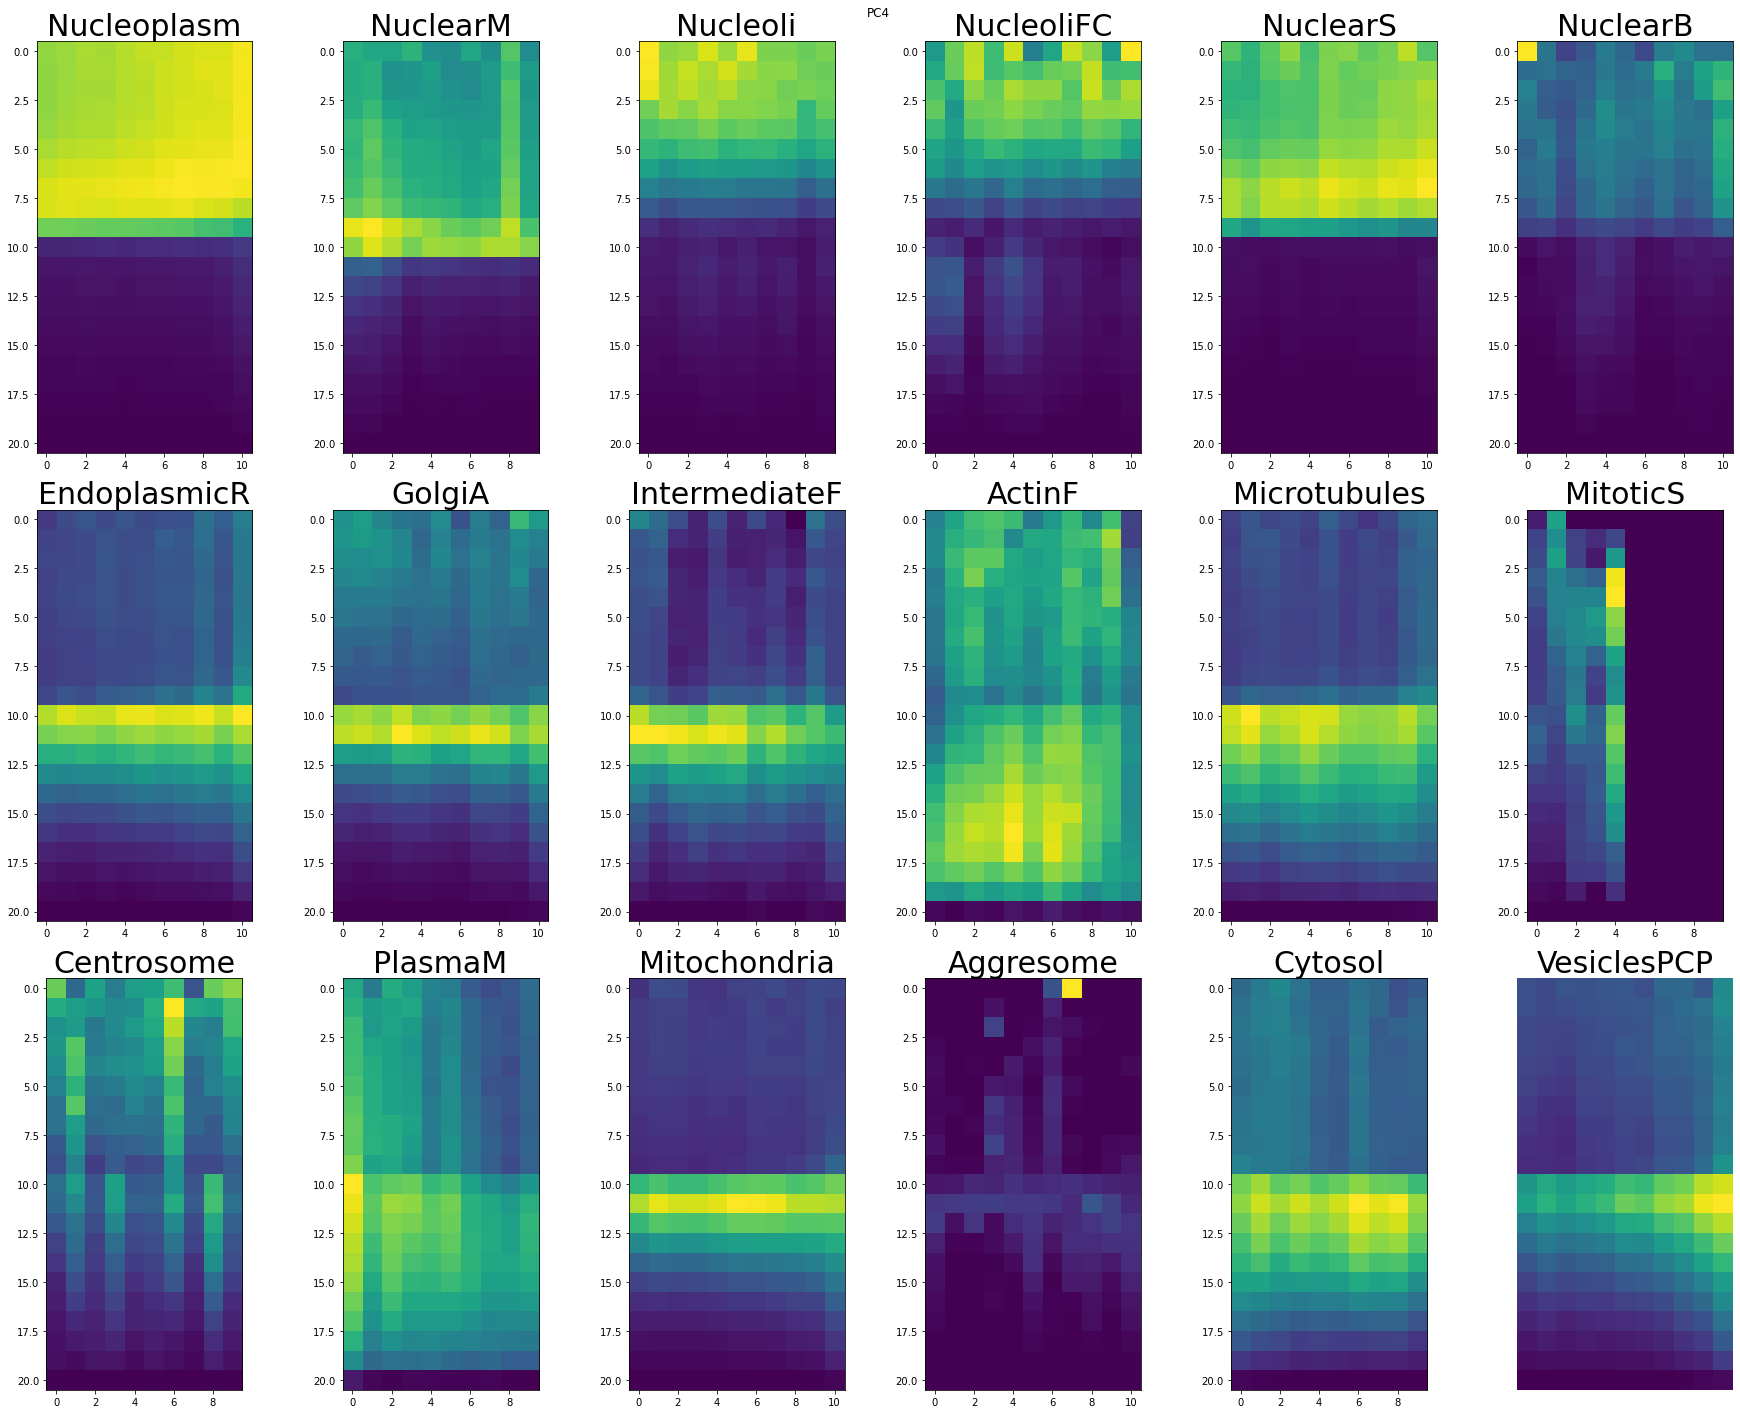

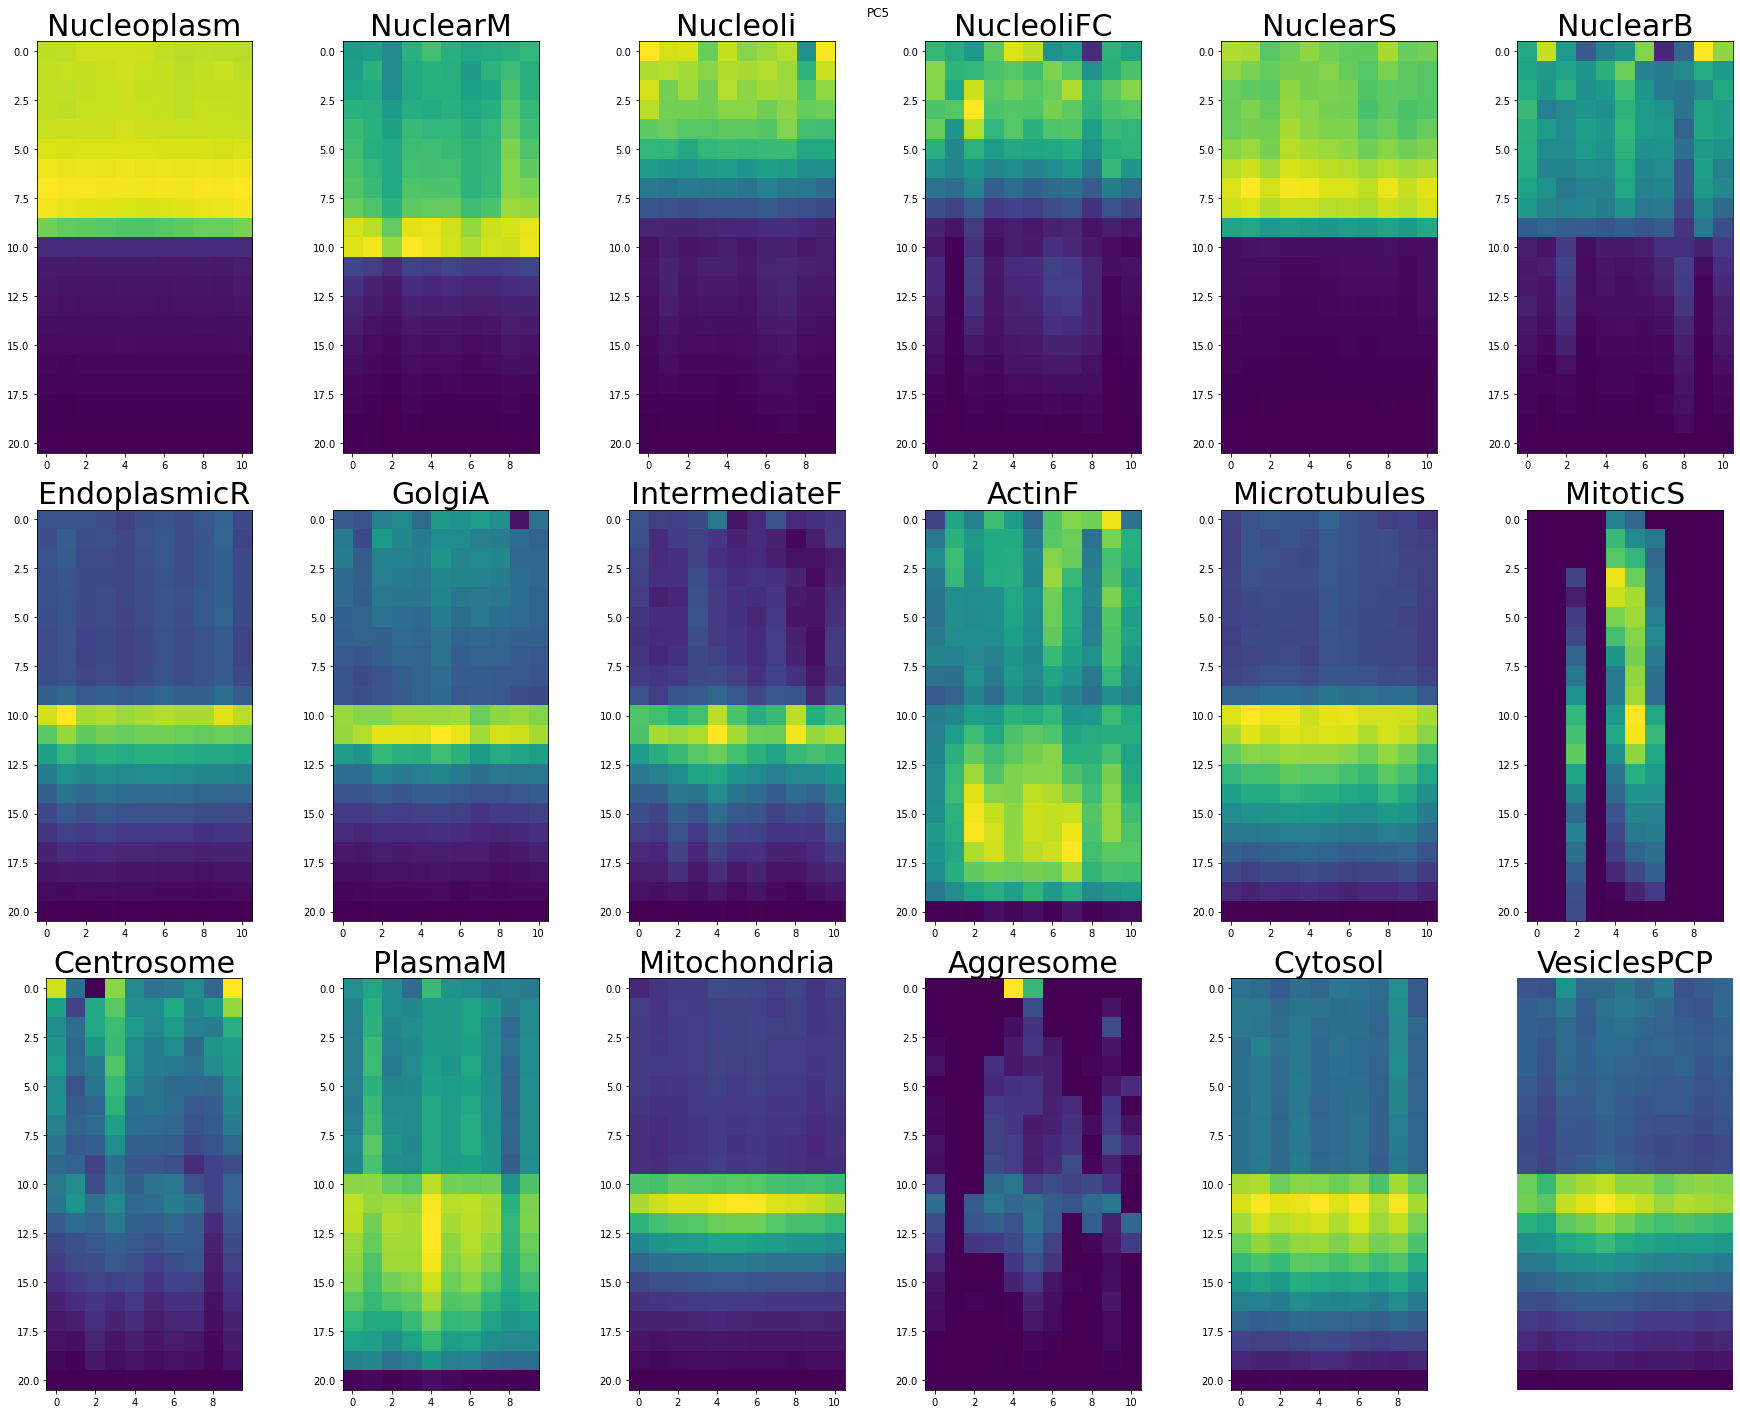

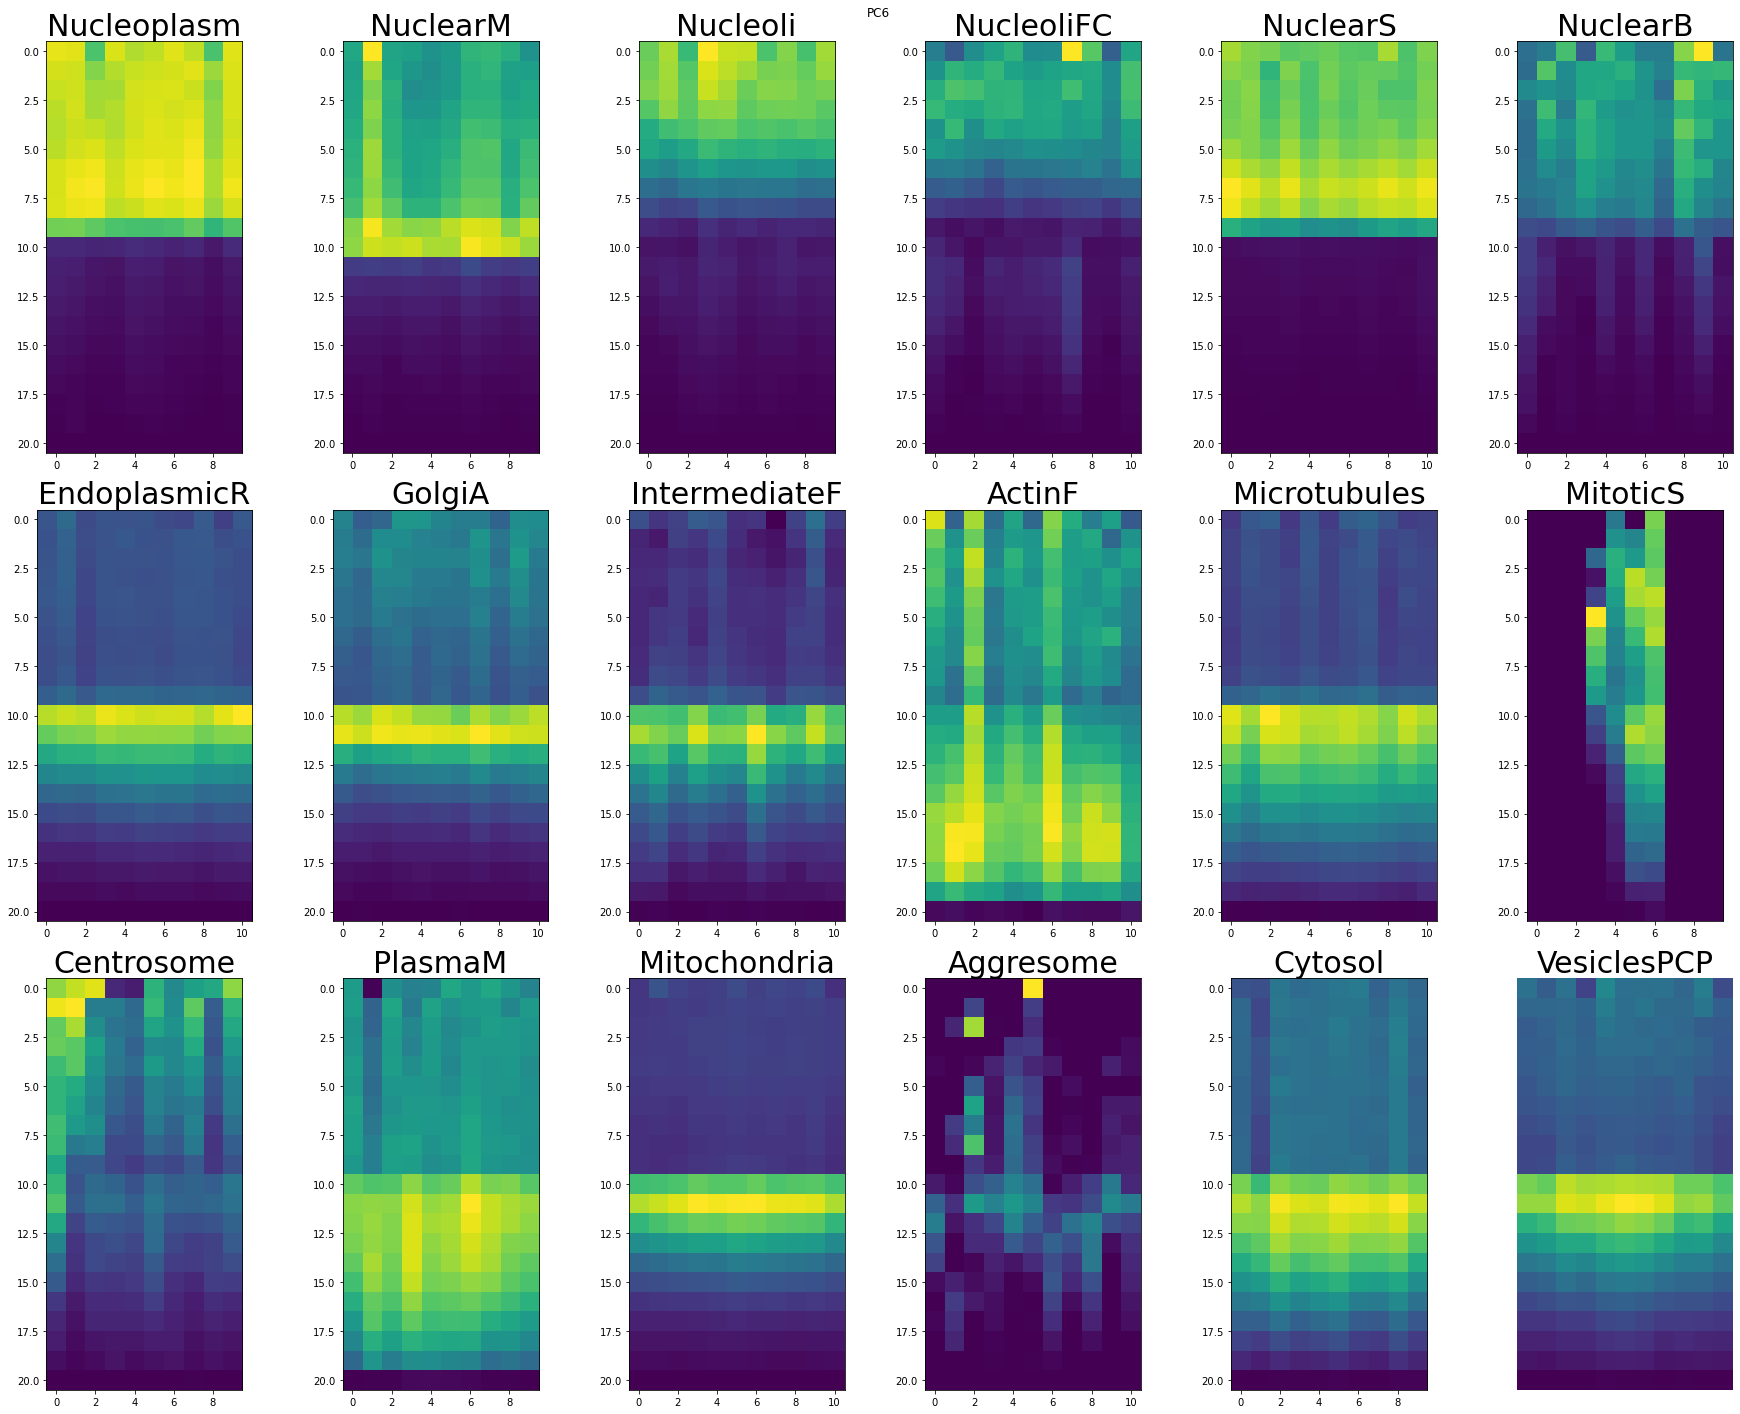

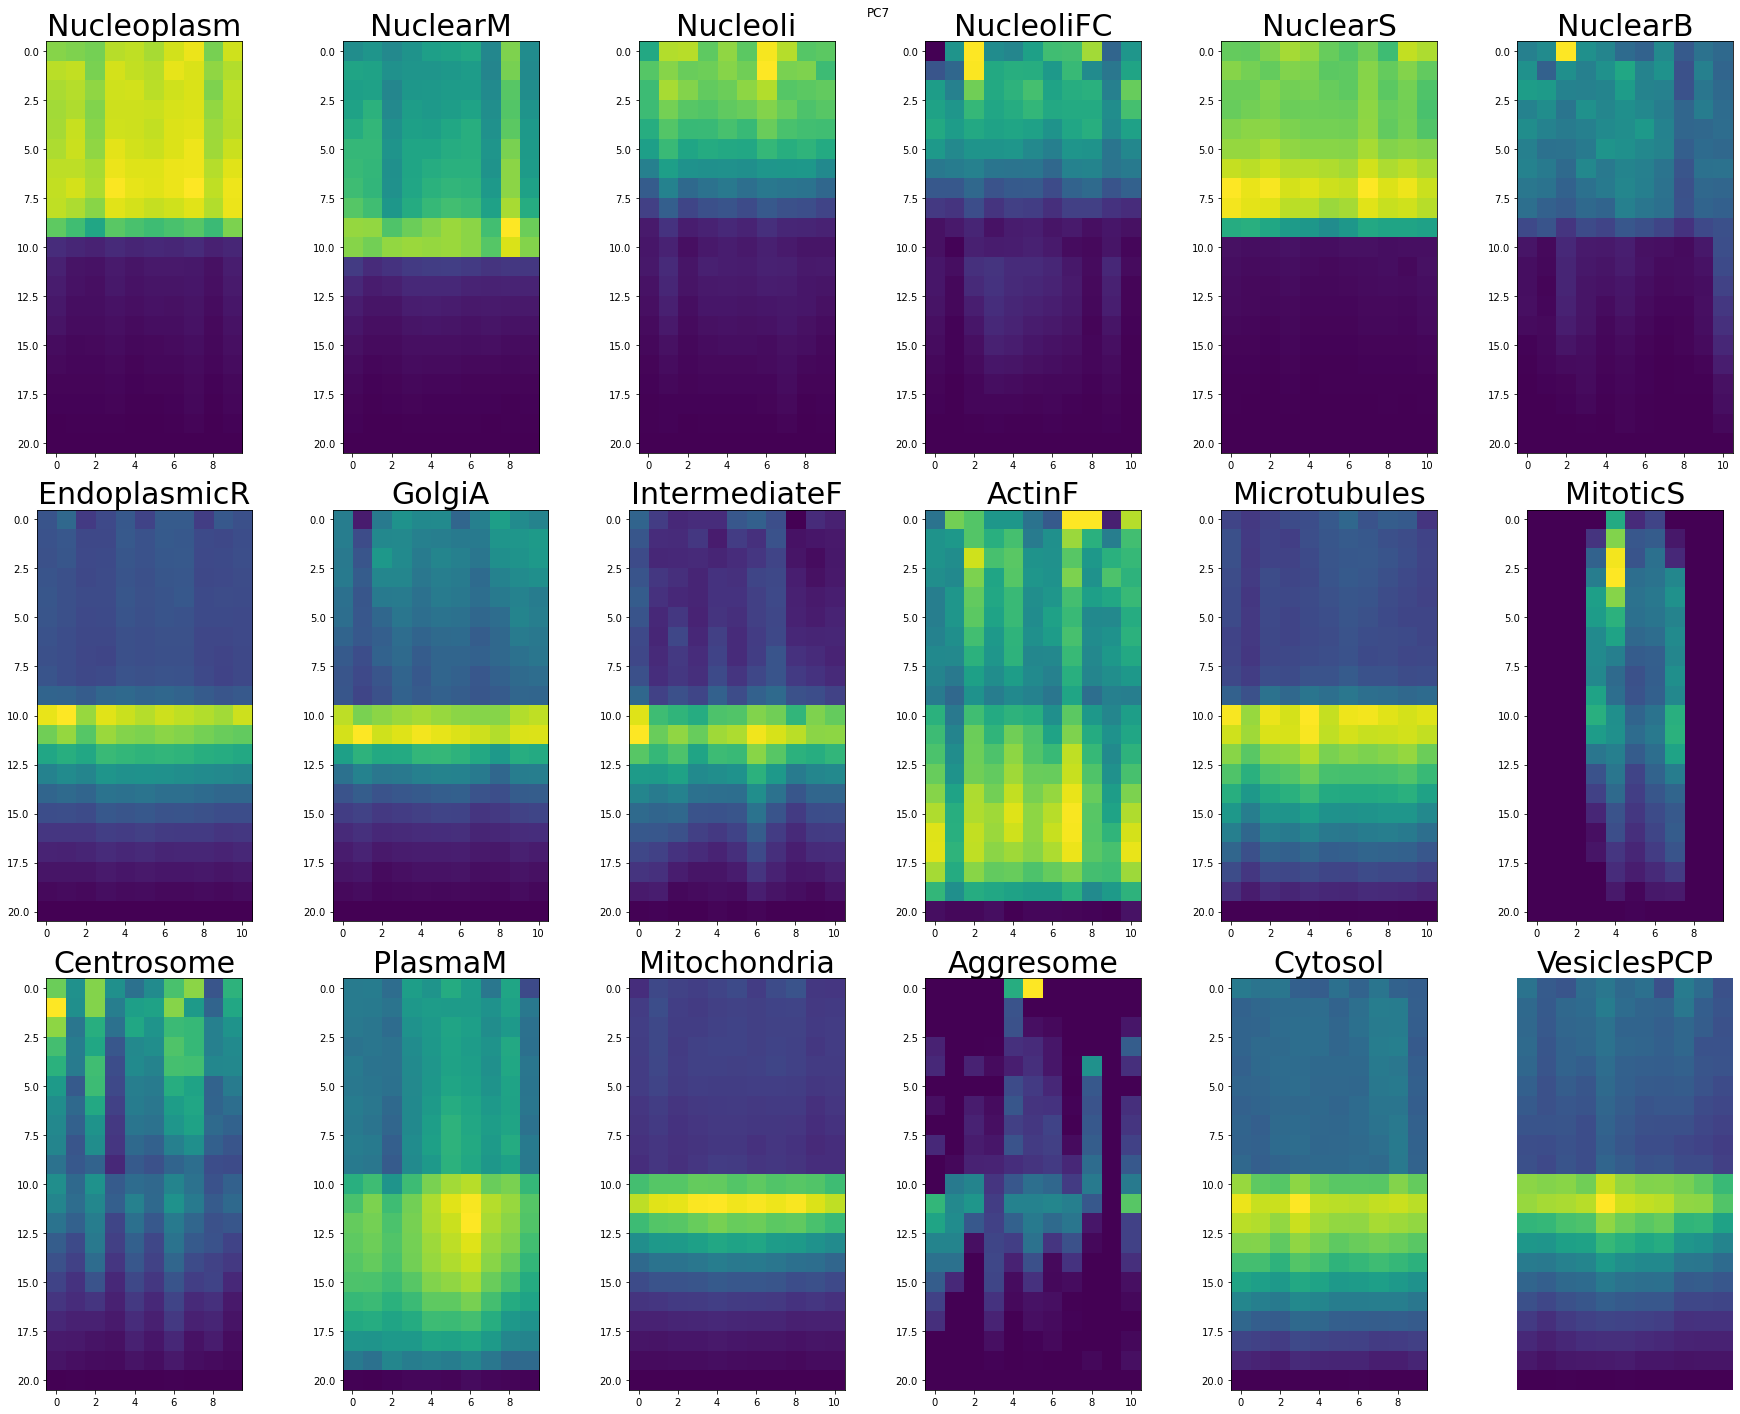

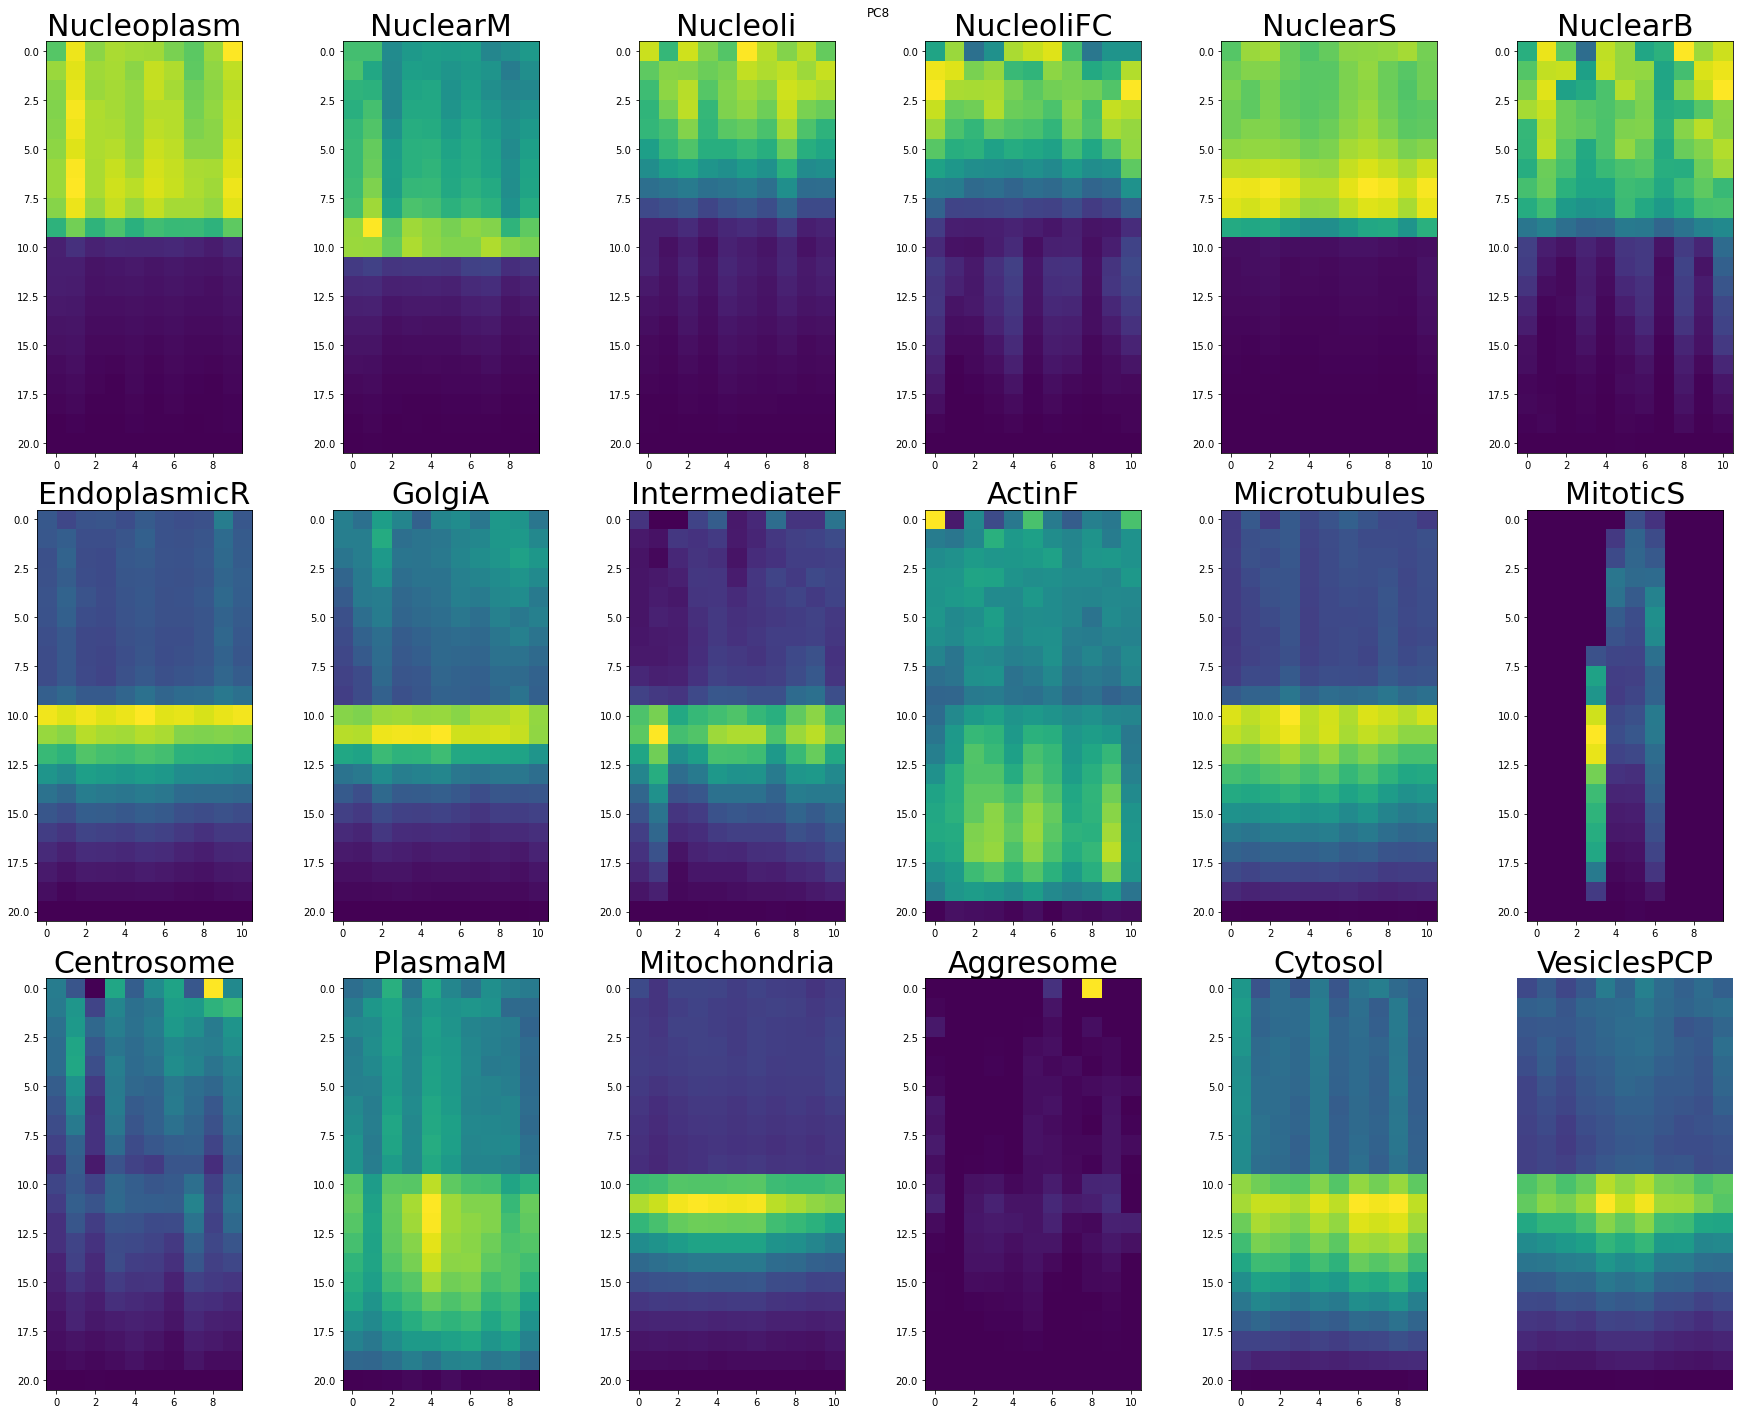

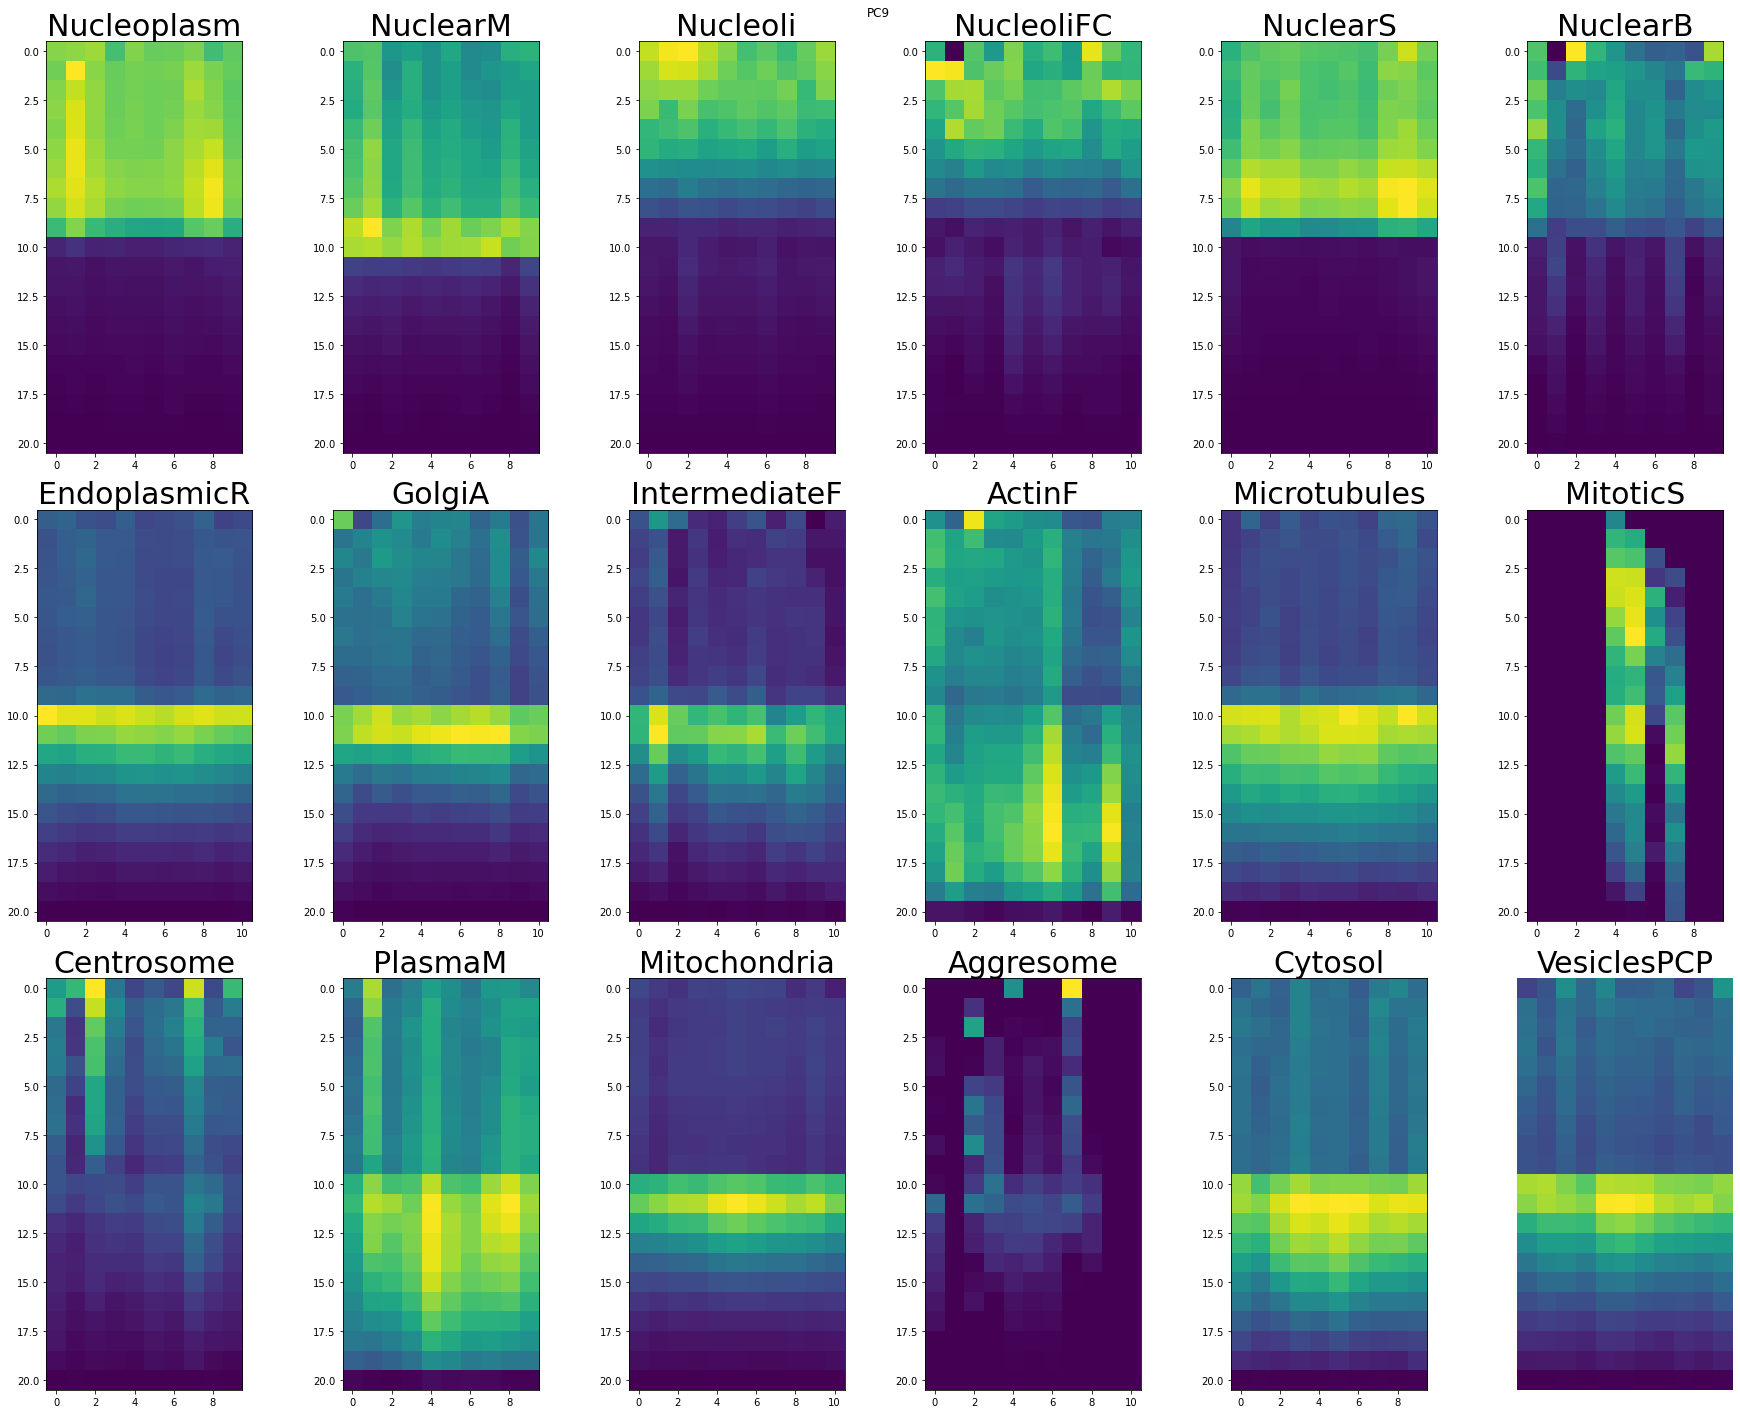

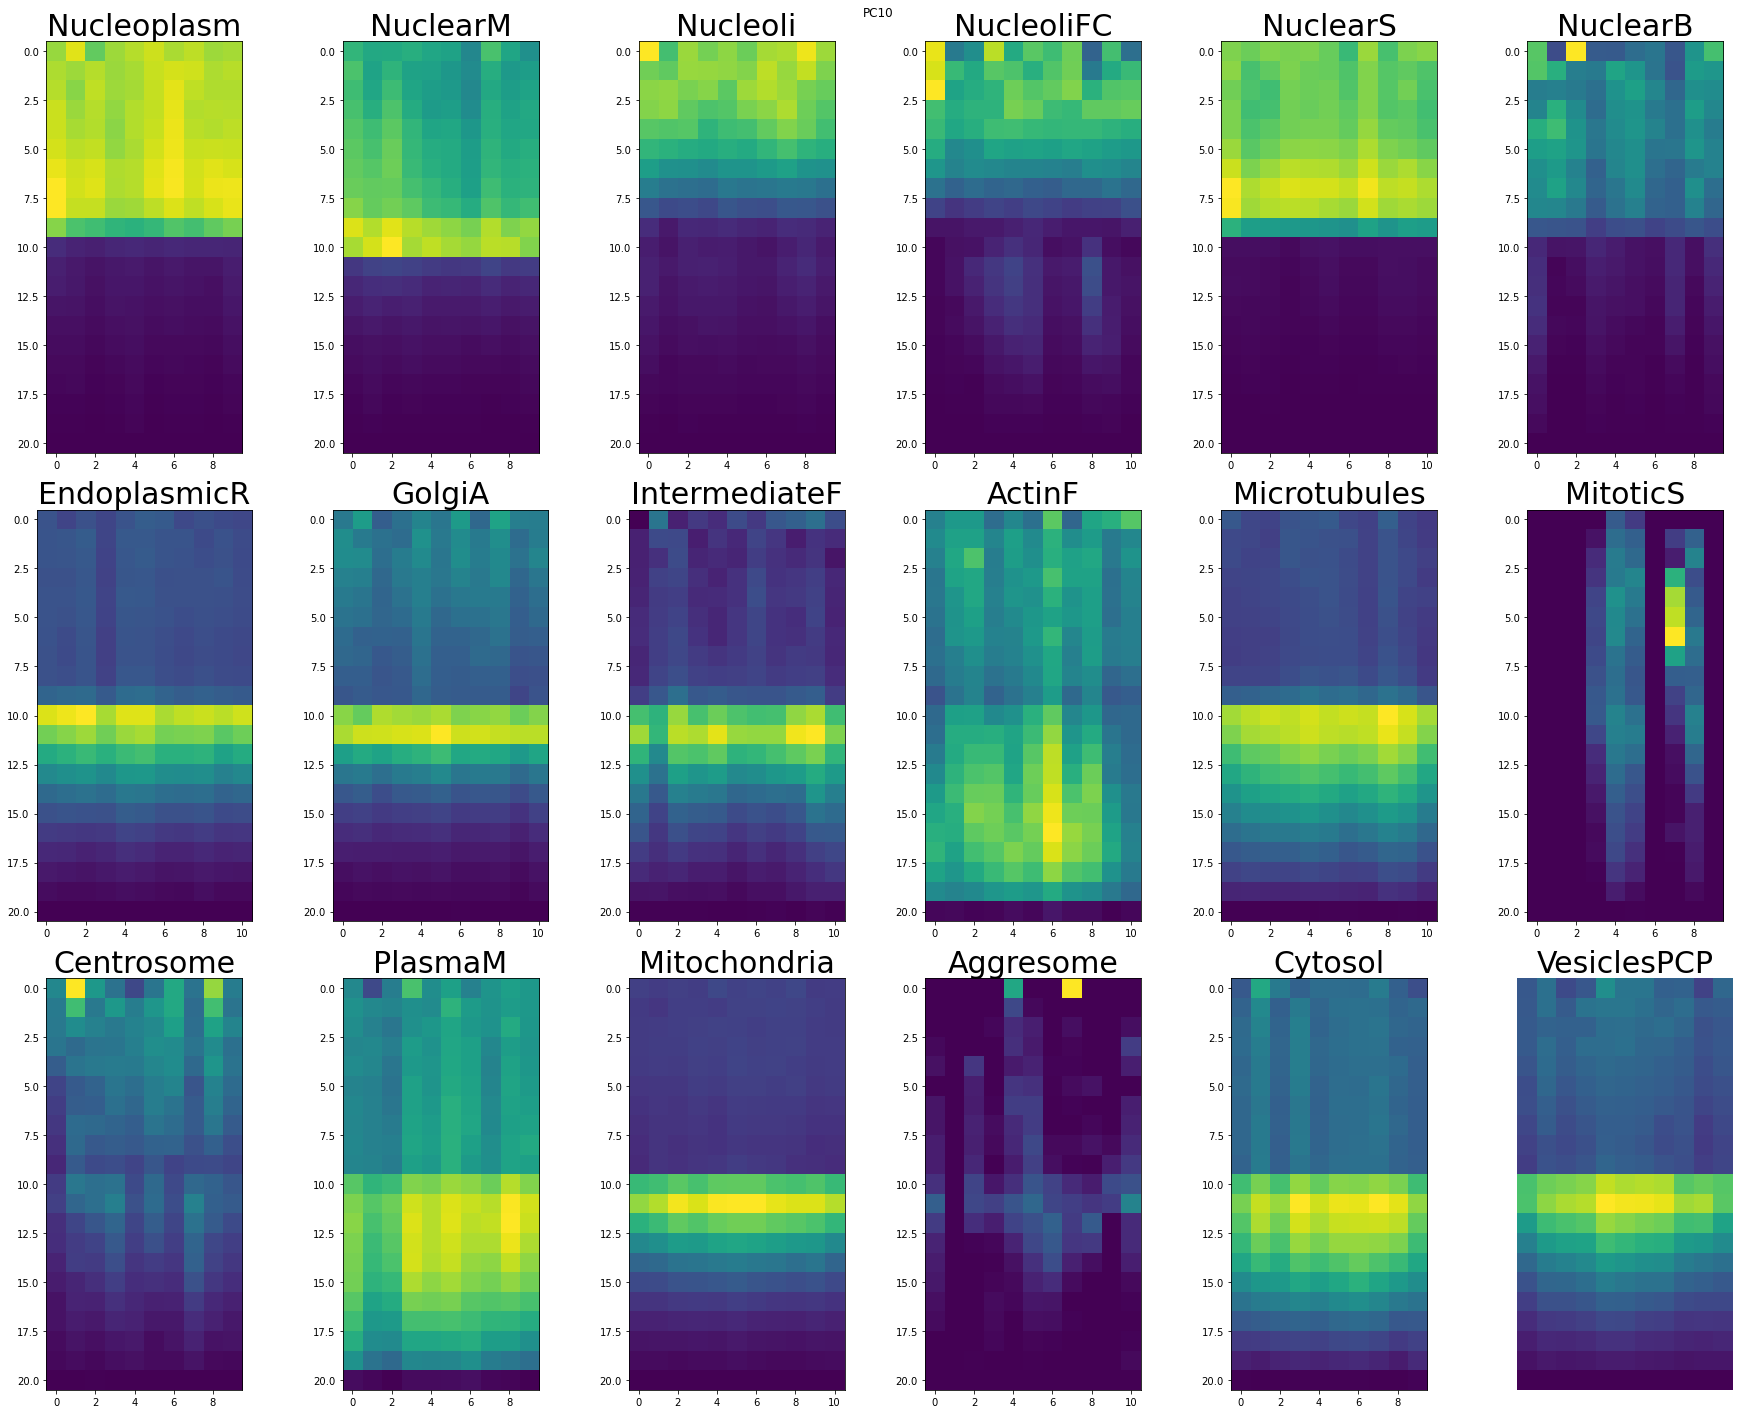

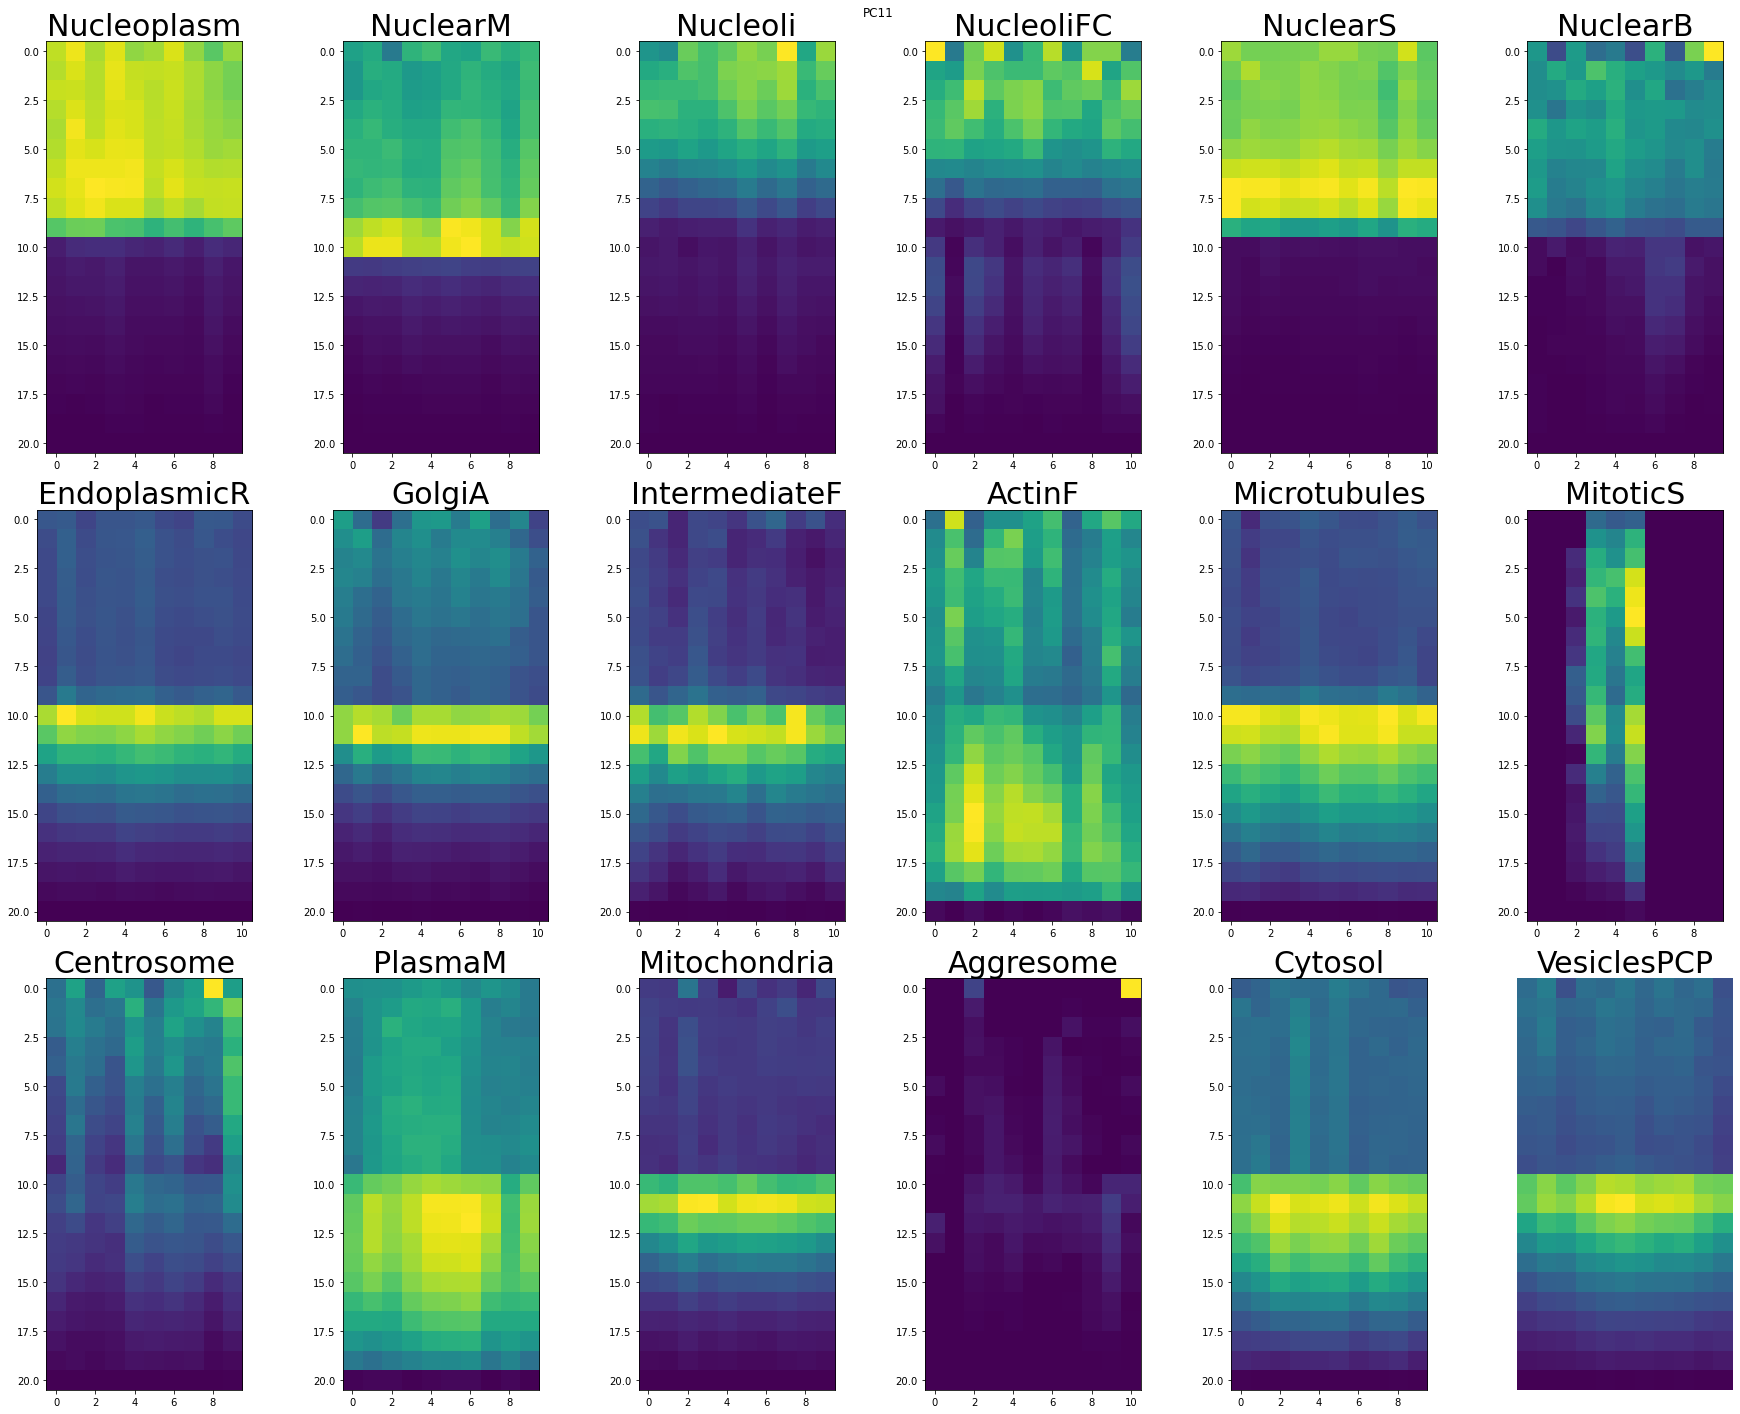

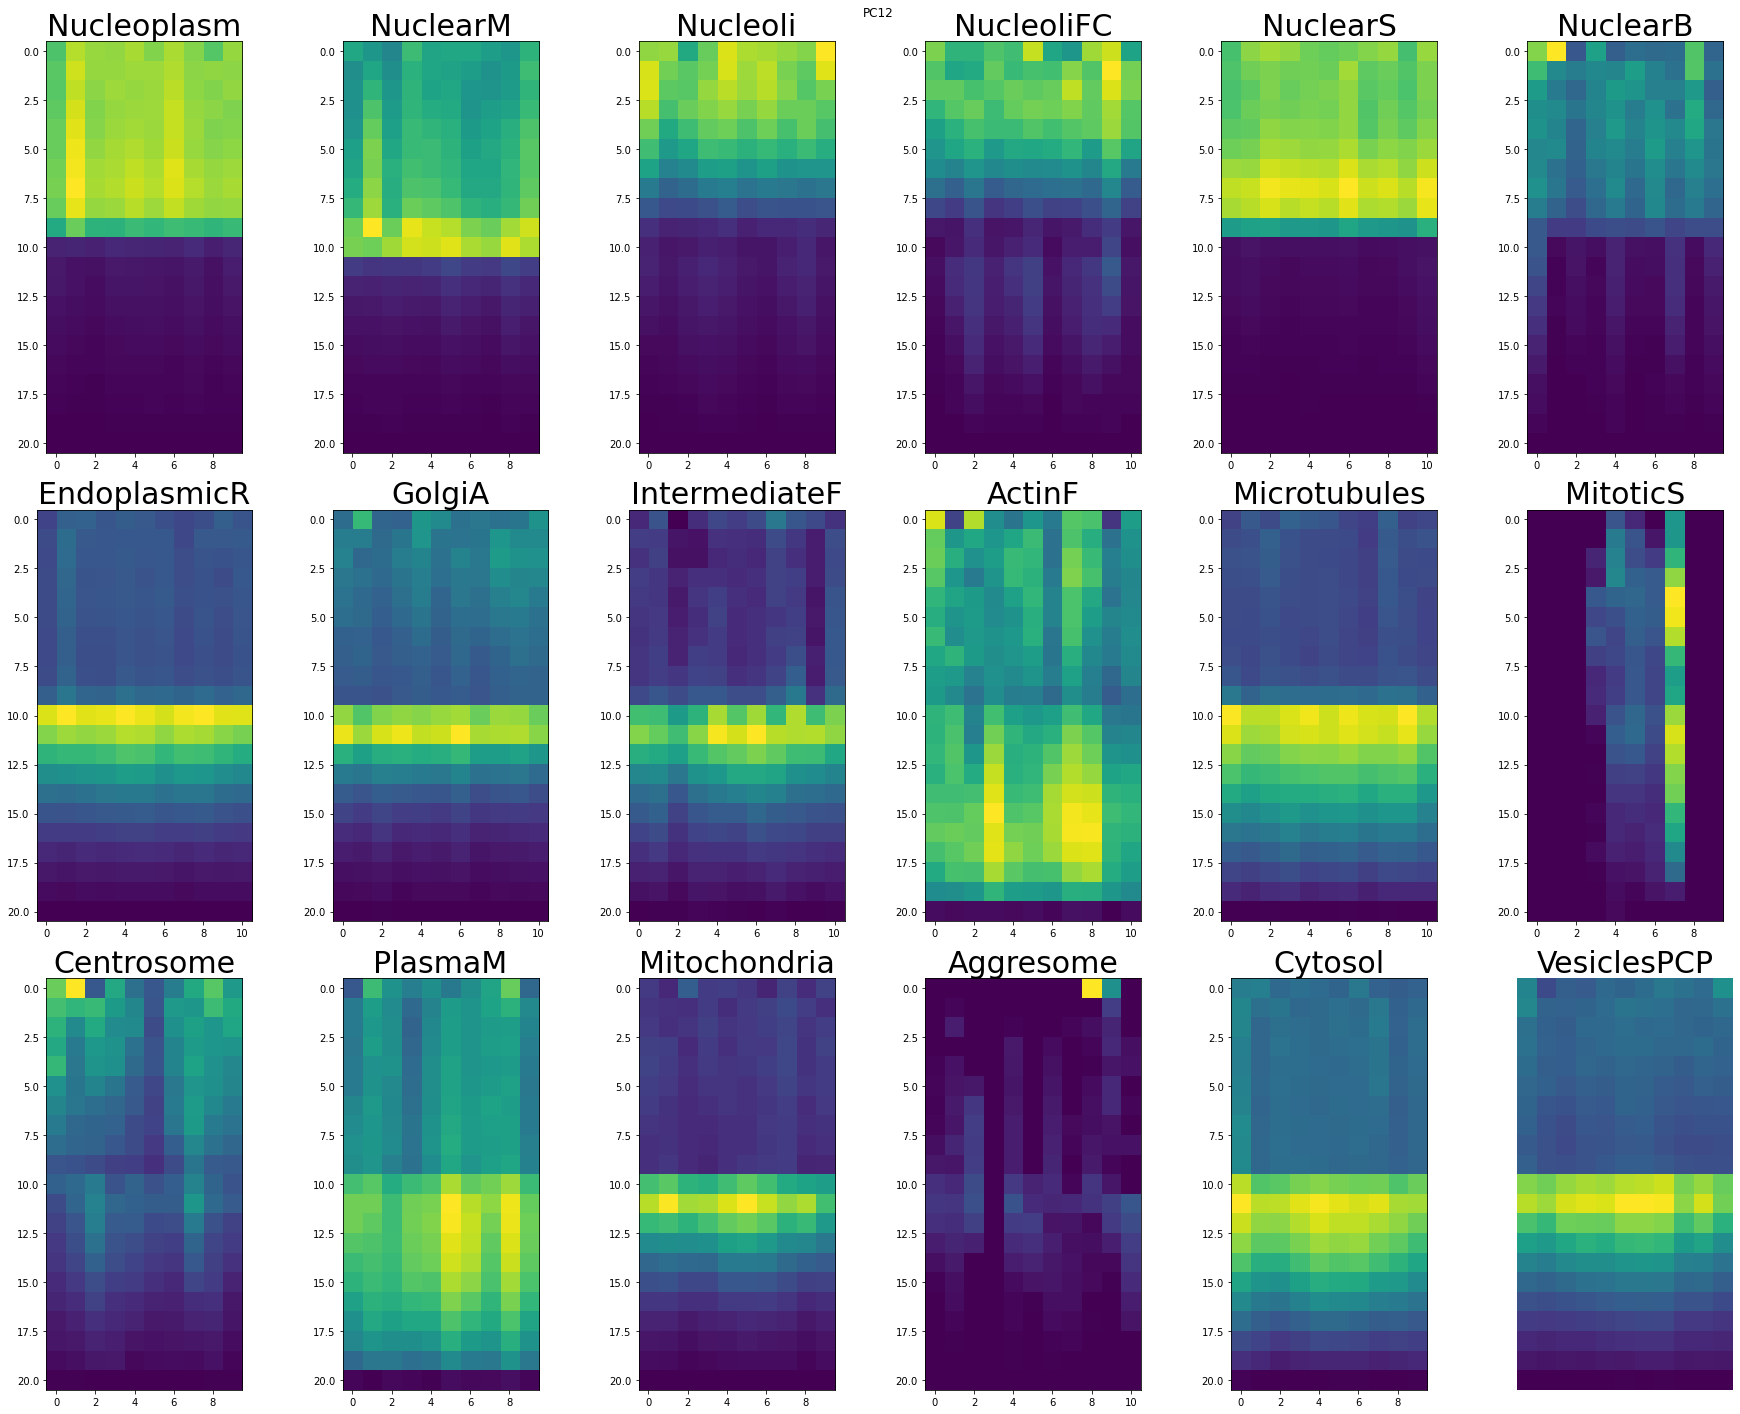

In [8]:
investigate_organell_pc_var()

In [9]:
df = pd.DataFrame({'float': [1.0],
                   'int': [1],
                   'datetime': [pd.Timestamp('20180310')],
                   'string': ['foo']})

In [47]:
d = "/mnt/c/Users/trang.le/Desktop/shapemode/covar_sc"
df = pd.read_csv(f"{d}/PC1_0_intensities.csv")

In [48]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,5369,5370,5371,5372,5373,5374,5375,cell_ids,ensembl_ids,cell_labs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,/scratch/users/tle1302/2Dshapespace/U-2_OS/sam...,ENSG00000168939,Cytosol
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,/scratch/users/tle1302/2Dshapespace/U-2_OS/sam...,"ENSG00000115041,ENSG00000120049,ENSG0000018213...",Negative
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,/scratch/users/tle1302/2Dshapespace/U-2_OS/sam...,"ENSG00000115041,ENSG00000120049,ENSG0000018213...",VesiclesPCP
3,3,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,/scratch/users/tle1302/2Dshapespace/U-2_OS/sam...,ENSG00000166436,Nucleoplasm
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,/scratch/users/tle1302/2Dshapespace/U-2_OS/sam...,ENSG00000166436,Multi-Location


In [13]:
df = df.drop('Unnamed: 0', axis=1)

In [18]:
df.cell_ids.count(), df.ensembl_ids.count(), df.shape

(90414, 90414, (90414, 5379))

In [39]:
mat = df.iloc[:,255:5376].values

In [63]:
np.save(f"{d}/samples", mat)

In [6]:
mat = np.load(f'{d}/samples.npy', mmap_mode='r')
e = pd.read_hdf(f'{d}/e.h5')
print(e)

               corr
s    t             
0    1     0.019487
     2     0.052661
     3    -0.502496
     4     0.027351
     5    -0.501884
...             ...
3996 3998 -0.007492
     3999  0.030654
3997 3998  0.106052
     3999  0.056136
3998 3999 -0.006964

[7998000 rows x 1 columns]


In [26]:
e = e.reset_index()

In [35]:
e["corr"][:10].values

array([ 0.01948733,  0.05266105, -0.5024964 ,  0.02735064, -0.50188422,
       -0.47021496, -0.42231003, -0.04230671, -0.02535901, -0.02271519])

In [41]:
#from scipy.stats import pearsonr
pr = []
for i in range(1,11):
    pr += [pearsonr(mat[0],mat[i])[0]]

In [42]:
pr

[0.014499504444432876,
 0.03918233185837863,
 -0.37388124994800176,
 0.020350176884454313,
 -0.3734257591207892,
 -0.34986232446949184,
 -0.31421877030622936,
 -0.03147820904523864,
 -0.018868311011920328,
 -0.016901182698595207]

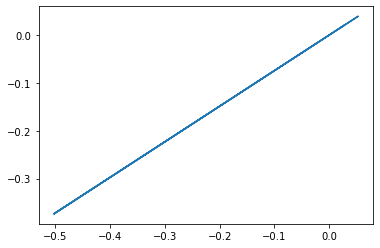

In [43]:
plt.plot(e["corr"][:10].values, pr)

In [45]:
mat[0].max()

1

In [13]:
e = pd.read_hdf(f'{d}/e.h5')
print(e)

               corr
s    t             
0    1     0.019487
     2     0.052661
     3    -0.502496
     4     0.027351
     5    -0.501884
...             ...
3996 3998 -0.007492
     3999  0.030654
3997 3998  0.106052
     3999  0.056136
3998 3999 -0.006964

[7998000 rows x 1 columns]


In [17]:
#(90000^2)/(4000*4000)
0.4/0.005625125

71.10953089931336

In [60]:
# protein content (intensity) plot against nucleus area (and cell area)
# 
# For G1 cells, more protein content in cytosol

# concentration (intensity/nuclear area) vs nucleus area

# protein content may be dependent of growth rate

# low abundance proteins should not be looked through fold chance specifically
# (10% change in low abundance protein is probably alot)